## Preprocessing

### Load all climate data (Precip & Soil Moisture) station F102 - F108

In [1]:
%run -i function_.py

In [2]:
current_directory = os.getcwd()
path_to_save = current_directory+r'/No_Discharge'
os.makedirs(path_to_save, exist_ok=True)

### Load all the precipitation in the stations

In [3]:
df_station = pd.read_excel(os.getcwd()+"/Inputs/Physiography Data.xlsx",
                           engine="openpyxl", sheet_name=None, skiprows=1,)

# Print the name of each sheets
station_name = list(df_station.keys())[:5]
print("There are 5 stations \n {}".format(station_name))


There are 5 stations 
 ['F102', 'F106', 'F107', 'F108', 'F110']


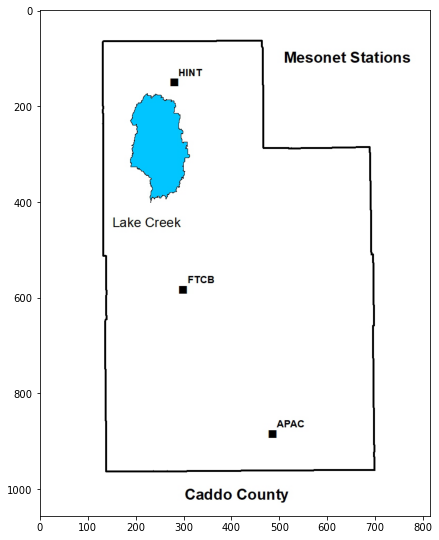

In [4]:
import matplotlib.image as img
import matplotlib.pyplot as plt

plt.subplots(figsize = (7,12))
# importing required libraries

# reading the image
im = img.imread(current_directory + r"/LakeCreek Caddo Mesonet.jpg")

# displaying the image
plt.imshow(im)
plt.show()

### Precipitation of all the stations

In [5]:
precipitation = df_station['F102'].iloc[:, :2].set_index('Date')

for i in station_name:
    precipitation = precipitation.merge(df_station[i].iloc[:, :2].set_index(
        'Date').rename(columns={'mm': i}), left_index=True, right_index=True)
precipitation = precipitation.drop(columns='mm')

precipitation = precipitation.replace([-996,-999], np.nan)
print(precipitation.describe())

              F102         F106         F107         F108         F110
count  5616.000000  5648.000000  3981.000000  5661.000000  5642.000000
mean      2.125741     2.066737     2.039206     2.019604     2.144523
std       7.847348     7.646972     7.632055     7.489740     8.103167
min       0.000000     0.000000     0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000     0.000000     0.000000
50%       0.000000     0.000000     0.000000     0.000000     0.000000
75%       0.000000     0.000000     0.000000     0.000000     0.000000
max     142.750000   171.450000   170.940000   160.270000   171.450000


<AxesSubplot:ylabel='Date'>

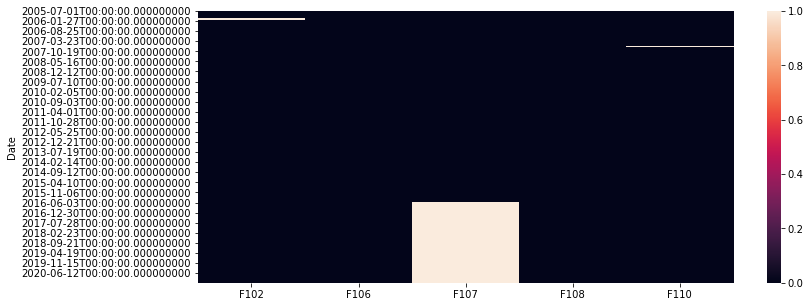

In [6]:
# Load the excel
data = pd.read_excel(os.getcwd()+"/Inputs/Physiography Data.xlsx",
                     engine="openpyxl", sheet_name=None, )

# plot the missing values in the timeseries
fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(precipitation.isna())


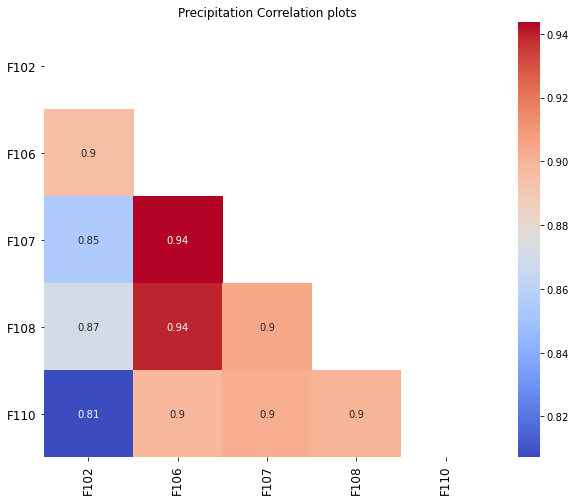

In [8]:
corr_plot(precipitation, 'Precipitation Correlation plots')


We choose the station with the most complete precipitation "F108".
<mark>F108</mark> has a high correlation with <mark>F106</mark> station that happens to be the next complete.
They both have the same soil property but different slopes


In [9]:
data["Soils_Slopes"]

Micronet Stations  Slope %       Texture  No. Layers  Max Depth (mm)
0              f102      5.9  LFS-FSL-SL-L           4            1829
1              f106      5.5      FSL-SICL           2            1727
2              f107      0.5      FSL-SICL           2            1727
3              f108      3.7      FSL-SICL           2            1727
4              f110      2.8      FSL-SICL           2            1727

### Load the Temperature data

We have a single temperature data for all the stations located in sheetnamae <mark> MESONET HINT_TEMP</mark>

In [10]:
# Obtain the Mesonet Temperature Min and Max temperature
Temperature = data["MESONET HINT_TEMP"].set_index('Date')
#Temperature.rename(columns={"TMAX (C)" : "TMAX ", 'TMIN (C)': "TMAX"})

# Merge the temperature and precipitation for the F108 station
df_F108 = Temperature.merge(precipitation['F108'], how='inner', on='Date')
df_F108 = df_F108.rename(columns={'F108': "PRCP (mm)"})

In [11]:
df_F108["CMS"] = data["Discharge"].set_index('Date').loc['2005-07-01':]

In [12]:
status(df_F108)

Features     Observations    No of missing   % Missing
----------  --------------  ---------------  ------------
TMAX (C)         5663              0         0.0%
TMIN (C)         5663              0         0.0%
PRCP (mm)        5663              2         0.0%
CMS              5663              0         0.0%


In [13]:
# replace all odd values due to instrument reading and linear interpolate
df_F108 = df_F108.replace(-571.105400, np.nan)
df_F108 = df_F108.interpolate(method='linear', limit_direction='both')
status(df_F108)


Features     Observations    No of missing   % Missing
----------  --------------  ---------------  ------------
TMAX (C)         5663              0         0.0%
TMIN (C)         5663              0         0.0%
PRCP (mm)        5663              0         0.0%
CMS              5663              0         0.0%


### Merge the soil properties, temperature and precipitation 

In [14]:


df_F108 = df_F108.merge(df_station['F108'].drop(columns='mm'),
                        how='inner', on='Date')

# set the date as the index of the dataframe
df_F108 = df_F108.set_index('Date')

# Rename the soil columns
df_F108 = df_F108.rename(columns={"5 cm": "SM 5 (cm)",
                                  "25 cm": "SM 25 (cm)",
                                  "45 cm": "SM 45 (cm)"})


### Deal with the missing values.

In [15]:
# replace all the -998  adn -996 with np.nan
df_F108 = df_F108.replace([-998, -996], np.nan)

status(df_F108)


Features     Observations    No of missing   % Missing
----------  --------------  ---------------  ------------
TMAX (C)         5663              0         0.0%
TMIN (C)         5663              0         0.0%
PRCP (mm)        5663              0         0.0%
CMS              5663              0         0.0%
SM 5 (cm)        5663             88         1.6%
SM 25 (cm)       5663             88         1.6%
SM 45 (cm)       5663             88         1.6%


<AxesSubplot:ylabel='Date'>

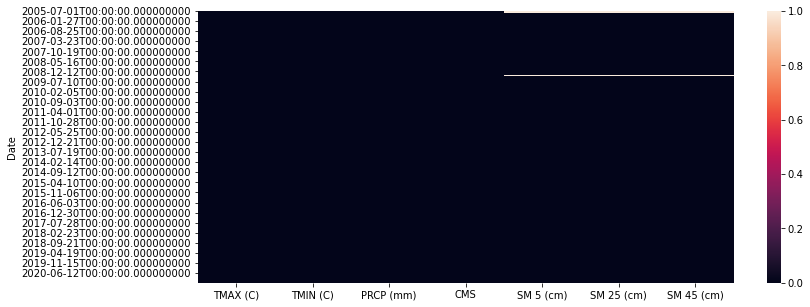

In [16]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(df_F108.isna())

In [17]:
display_side_by_side([sequence_of_missing_values(df_F108, 'SM 5 (cm)'),
                     sequence_of_missing_values(df_F108, 'SM 25 (cm)'), sequence_of_missing_values(df_F108, 'SM 45 (cm)')],
                     ['5cm', '25cm', '45cm']
                     )

Drop the first 56 rows till 2005-08-26 and linear interpolate the dataframe

In [18]:
df_F108 = df_F108.loc['2005-08-26':].interpolate(
    method='linear', limit_direction='both')
status(df_F108)

Features     Observations    No of missing   % Missing
----------  --------------  ---------------  ------------
TMAX (C)         5607              0         0.0%
TMIN (C)         5607              0         0.0%
PRCP (mm)        5607              0         0.0%
CMS              5607              0         0.0%
SM 5 (cm)        5607              0         0.0%
SM 25 (cm)       5607              0         0.0%
SM 45 (cm)       5607              0         0.0%


## F108 suggested Correction 

In [19]:
# 1-- Remove data prior to Dec-01-2006, as SM-45 sensor does not seem to work correctly

condition = df_F108.index >= '2006-12-01'
df_F108 = df_F108.loc[condition]

# 2-- A spike in SM-45 between Nov-2008 and Dec 2008 does not seem to be accurate
#     find out when this happened (date), replace it with NaN, and then fill-in via interpolation
condition = (df_F108.index > '2008-11-01') & (df_F108.index < '2008-12-01') & \
            (df_F108[df_F108.columns[6]] > 0.4)
print(df_F108.loc[condition, 'SM 45 (cm)'])

df_F108.loc[condition, 'SM 45 (cm)'] == np.NaN
df_F108['SM 45 (cm)'].interpolate(method='linear',
                                  limit_direction='both', inplace=True)
#print(status(df_F108))

# the rest of the data seems to be suitable for the analysis
#------------------------------------------------------------
# data size
print('sample size', len(df_F108))

Date
2008-11-24    0.49
Name: SM 45 (cm), dtype: float64
sample size 5145


In [20]:
# 1  - Soil moisture content is a dimensionless quantity, expressed as a volumetric fraction

df_F108.rename(columns = {'SM 5 (cm)'  : 'SM 5 (-)', 
                          'SM 25 (cm)' : 'SM 25 (-)', 
                          'SM 45 (cm)' : 'SM 45 (-)'},
                           inplace = True )

df_F108.describe()

TMAX (C)     TMIN (C)    PRCP (mm)          CMS     SM 5 (-)  \
count  5145.000000  5145.000000  5145.000000  5145.000000  5145.000000   
mean     21.975308     9.108276     2.058008     0.284911     0.198272   
std      10.732579     9.865678     7.569040     1.487521     0.091318   
min     -11.810993   -20.049799     0.000000     0.002264     0.030000   
25%      14.249857     0.694438     0.000000     0.090277     0.130000   
50%      22.921993     9.538794     0.000000     0.151405     0.190000   
75%      30.977468    18.322039     0.000000     0.211118     0.250000   
max      43.627341    27.388615   160.270000    68.486000     0.460000   

         SM 25 (-)    SM 45 (-)  
count  5145.000000  5145.000000  
mean      0.255364     0.195617  
std       0.060546     0.050284  
min       0.000000     0.000000  
25%       0.210000     0.160000  
50%       0.270000     0.200000  
75%       0.300000     0.230000  
max       0.400000     0.490000

## Feature Engineering

- create median and mean precipitations weekly and yearly frequency. 
- check the correlation between features on both time format.
- load the yearly yield
- Split the data into train and test
- Create the pipeline no tuning yet
-- XGBoost
-- Catboost
-- Random Forest
-- ExtraTree

### Correlation plots

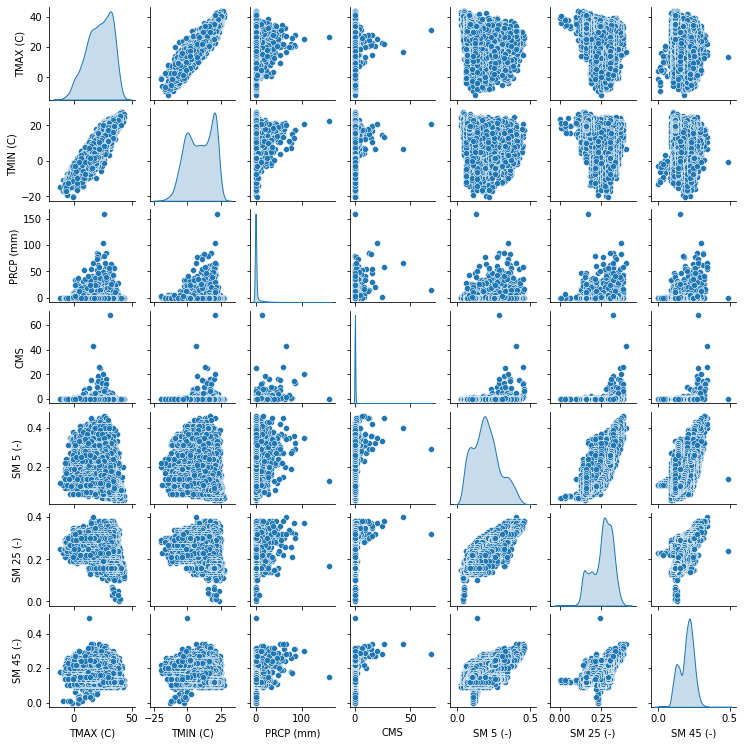

In [21]:
sns.pairplot(df_F108, diag_kind='kde', height=1.5)

### Correlation on daily data

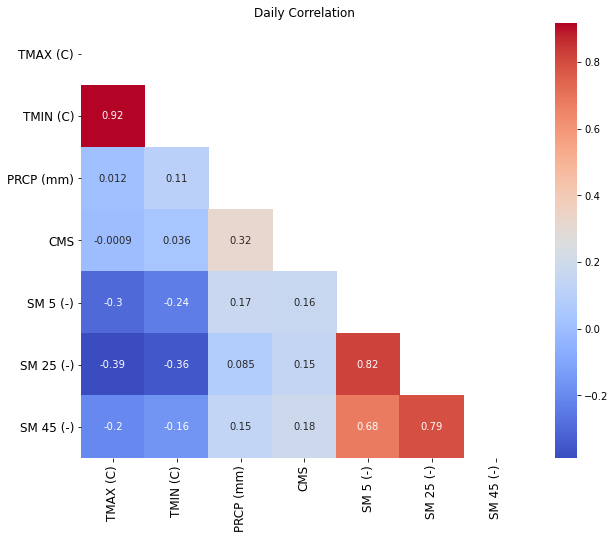

In [22]:
corr_plot(df_F108, 'Daily Correlation')

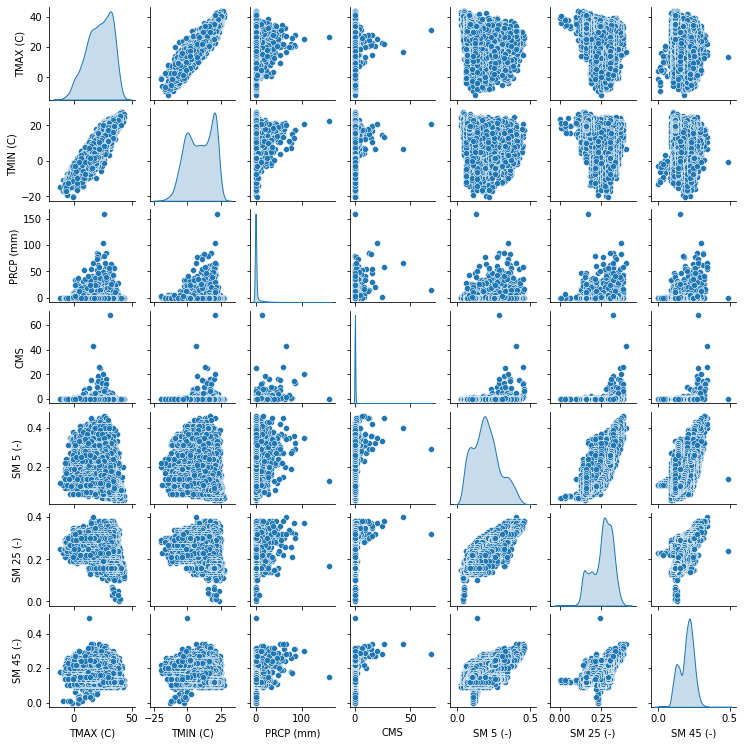

In [23]:
sns.pairplot(df_F108, diag_kind='kde', height=1.5)

## Daily Analysis

In [24]:
df_AI = df_F108.copy()
df_AI.rename(columns={'TMAX (C)'  : '$T_{max}$ [$^oC$]', 
                      'TMIN (C)'  : '$T_{min}$ [$^oC$]',
                      'PRCP (mm)' : '$P$ [$mm$]'         ,      
                      'CMS'       : '$Q [$m^3/s$]$'    , 
                      'SM 5 (-)'  : '$\theta_5$ [-]'   ,
                      'SM 25 (-)' : '$\theta_{25}$ [-]',
                      'SM 45 (-)' : '$\theta_{45}$ [-]'  }, inplace = True)

df_AI['Month'] = df_AI.index.month
df_AI

# Precipitation Lags
#df_AI['$P^{lag1} [mm]$'] = df_AI["$P [mm]$"].shift(1)
#df_AI['$P^{lag2} [mm]$'] = df_AI["$P [mm]$"].shift(2)

# Sort the columns
month  = df_AI.loc[:, df_AI.columns.str.startswith('M')]
prcp   = df_AI.loc[:, df_AI.columns.str.startswith('$P')]
temp   = df_AI.loc[:, df_AI.columns.str.startswith('$T')]
ds     = df_AI.loc[:, df_AI.columns.str.startswith('$Q')]
sm     = df_AI.loc[:, df_AI.columns.str.startswith('$\t')]

Features = list(df_AI.drop(columns=sm.columns.append(ds.columns)).columns)

df_AI = month.merge(temp, on='Date').merge(prcp, on='Date').merge(
    ds, on="Date").merge(sm, on="Date").dropna()

df_AI.head()


Month  $T_{max}$ [$^oC$]  $T_{min}$ [$^oC$]  $P$ [$mm$]  \
Date                                                                  
2006-12-01     12           2.294421         -13.299867        4.83   
2006-12-02     12           2.699973          -8.611025        0.76   
2006-12-03     12           3.238856          -6.122161        0.00   
2006-12-04     12           7.916588          -5.038838        0.00   
2006-12-05     12          13.127647          -2.799972        0.00   

            $Q [$m^3/s$]$  $\theta_5$ [-]  $\theta_{25}$ [-]  \
Date                                                           
2006-12-01       0.096220            0.15               0.18   
2006-12-02       0.108389            0.16               0.18   
2006-12-03       0.098484            0.17               0.19   
2006-12-04       0.089428            0.19               0.23   
2006-12-05       0.092541            0.20               0.26   

            $\theta_{45}$ [-]  
Date                           
2006-12-01               0.12  
2006-12-02               0.12  
2006-12-03               0.12  
2006-12-04               0.12  
2006-12-05               0.12

### Daily SM_5 ($\theta_5$)

+-------------------------------+
|       Training set Score      |
+--------------+----------+-----+
|  Algorithm   | R-square | MSE |
+--------------+----------+-----+
| RandomForest |   0.88   | 0.0 |
|   XGBoost    |   0.76   | 0.0 |
|  ExtraTree   |   1.0    | 0.0 |
+--------------+----------+-----+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.81   | 0.04 |
|   XGBoost    |   0.83   | 0.04 |
|  ExtraTree   |   0.87   | 0.03 |
+--------------+----------+------+


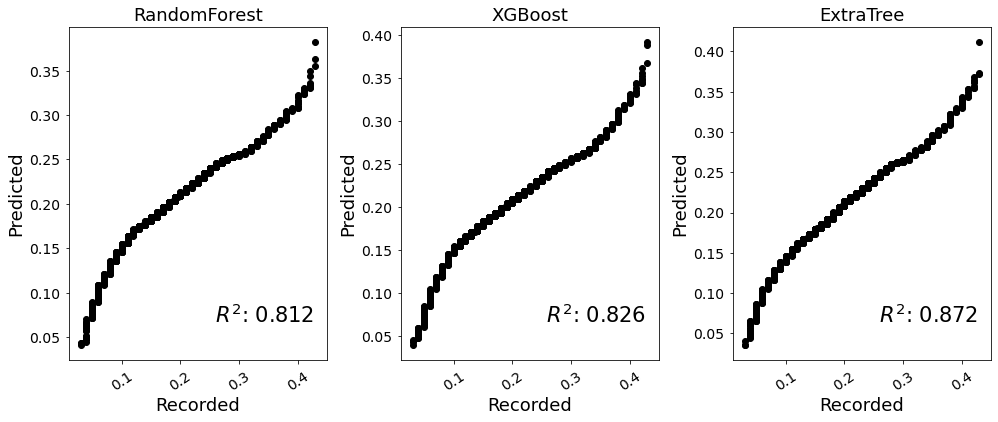

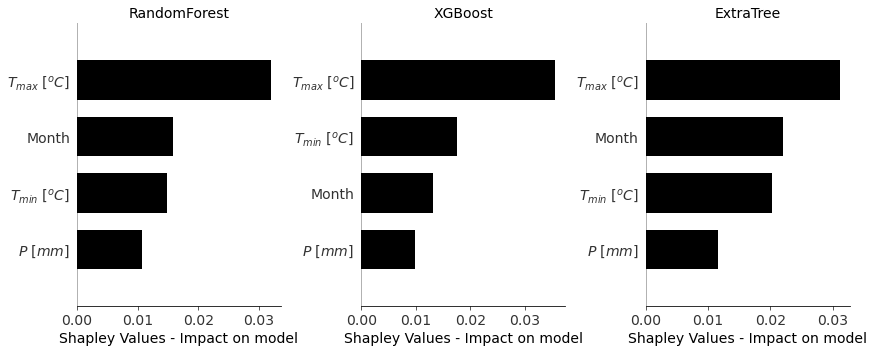

In [25]:
X = df_AI[Features].values # Tmax, Tmin, P, Q
y = df_AI.iloc[:, 5].values  # SM 5cm


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.ravel(),
                                                    test_size=0.3,)


pipeline_RF     = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB    = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner       = [pipeline_RF, pipeline_XGB, pipeline_ExTree]

holdem = results(X_train, y_train, X_test, y_test, pipeliner)
print_results(holdem, y_test)


Soil = "daily_SM5"

feature_importance(path_to_save, Soil, pipeliner, X, y)

### Daily SM_25  ($\theta_{25}$)

+-------------------------------+
|       Training set Score      |
+--------------+----------+-----+
|  Algorithm   | R-square | MSE |
+--------------+----------+-----+
| RandomForest |   0.89   | 0.0 |
|   XGBoost    |   0.78   | 0.0 |
|  ExtraTree   |   1.0    | 0.0 |
+--------------+----------+-----+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.89   | 0.02 |
|   XGBoost    |   0.89   | 0.02 |
|  ExtraTree   |   0.91   | 0.02 |
+--------------+----------+------+


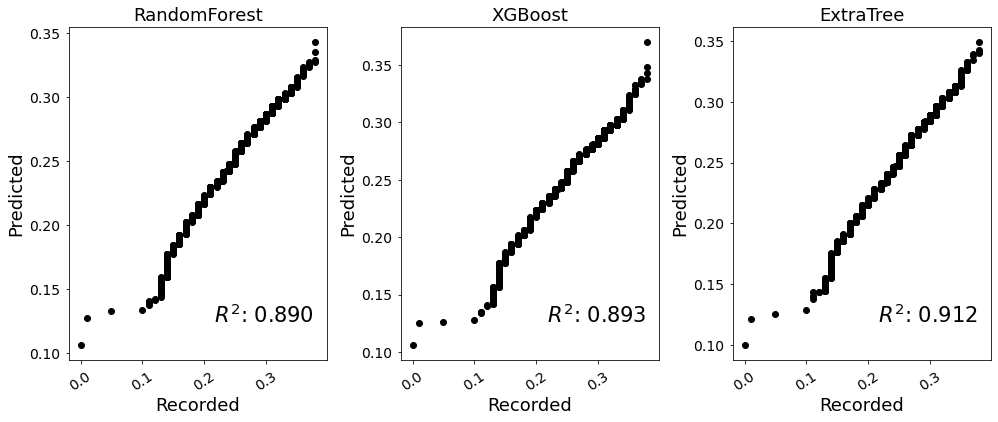

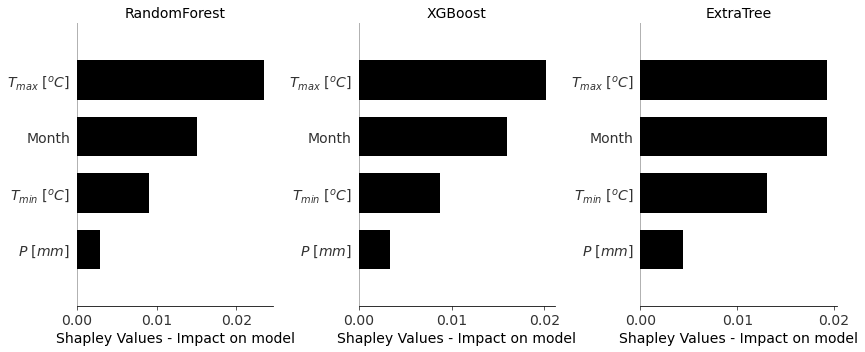

In [26]:
X = df_AI[Features].values
y = df_AI.iloc[:,6].values  # SM 25cm


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.ravel(),
                                                    test_size=0.3)


pipeline_RF     = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB    = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner       = [pipeline_RF, pipeline_XGB, pipeline_ExTree]

holdem = results(X_train, y_train, X_test, y_test, pipeliner)

print_results(holdem, y_test)


Soil = "daily_SM25"

feature_importance(path_to_save, Soil, pipeliner, X, y)


### Daily SM_45 ($\theta_{45}$)

+-------------------------------+
|       Training set Score      |
+--------------+----------+-----+
|  Algorithm   | R-square | MSE |
+--------------+----------+-----+
| RandomForest |   0.89   | 0.0 |
|   XGBoost    |   0.78   | 0.0 |
|  ExtraTree   |   1.0    | 0.0 |
+--------------+----------+-----+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.84   | 0.02 |
|   XGBoost    |   0.86   | 0.02 |
|  ExtraTree   |   0.88   | 0.02 |
+--------------+----------+------+


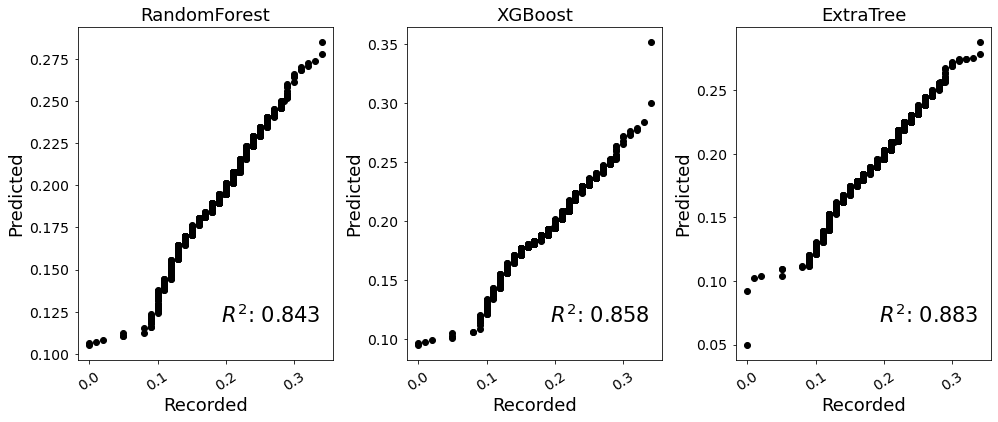

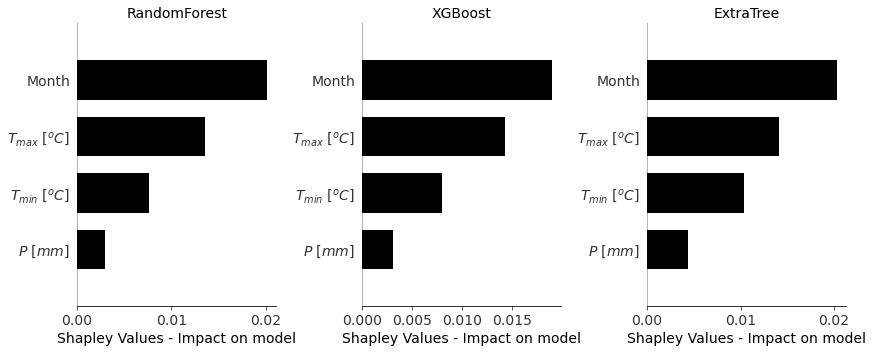

In [27]:
X = df_AI[Features].values
y = df_AI.iloc[:, 7].values  # SM 45cm


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.ravel(),
                                                    test_size=0.3)


pipeline_RF     = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB    = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner       = [pipeline_RF, pipeline_XGB, pipeline_ExTree]

holdem = results(X_train, y_train, X_test, y_test, pipeliner)
print_results(holdem, y_test)


Soil = "daily_SM45"

feature_importance(path_to_save, Soil, pipeliner, X, y)


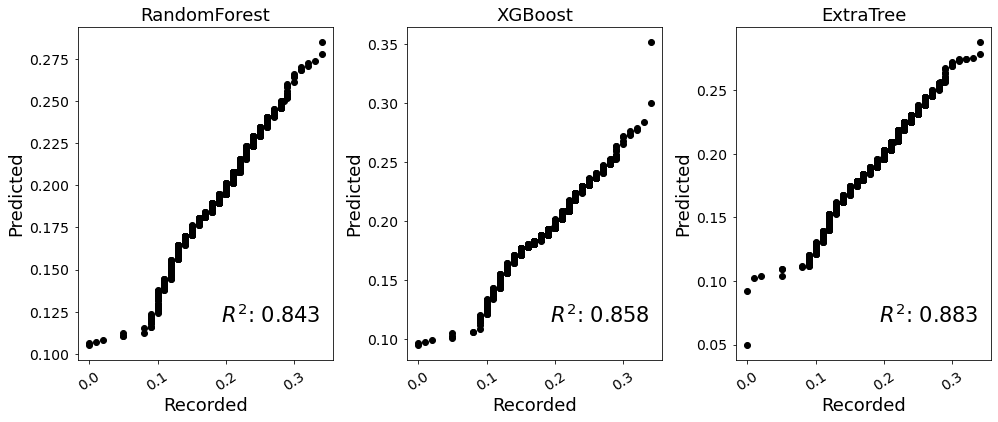

In [28]:
print_results(holdem,y_test)

Lags were ommited on the daily scale 

## Daily Analysis with lags

In [29]:
df_AI = df_F108.copy()
df_AI.rename(columns={'TMAX (C)'  : '$T_{max}$ [$^oC$]', 
                      'TMIN (C)'  : '$T_{min}$ [$^oC$]',
                      'PRCP (mm)' : '$P$ [$mm$]'         ,      
                      'CMS'       : '$Q [$m^3/s$]$'    , 
                      'SM 5 (-)'  : '$\theta_5$ [-]'   ,
                      'SM 25 (-)' : '$\theta_{25}$ [-]',
                      'SM 45 (-)' : '$\theta_{45}$ [-]'  }, inplace = True)

df_AI['Month'] = df_AI.index.month


# Precipitation Lags
df_AI['$P_{-1}$ [mm]'] = df_AI['$P$ [$mm$]'].shift(1)
df_AI['$P_{-2}$ [mm]'] = df_AI['$P$ [$mm$]'].shift(2)

# Precipitation Lags
#df_AI['$P^{lag1} [mm]$'] = df_AI["$P [mm]$"].shift(1)
#df_AI['$P^{lag2} [mm]$'] = df_AI["$P [mm]$"].shift(2)

# Sort the columns
month  = df_AI.loc[:, df_AI.columns.str.startswith('M')]
prcp   = df_AI.loc[:, df_AI.columns.str.startswith('$P')]
temp   = df_AI.loc[:, df_AI.columns.str.startswith('$T')]
ds     = df_AI.loc[:, df_AI.columns.str.startswith('$Q')]
sm     = df_AI.loc[:, df_AI.columns.str.startswith('$\t')]

Features = list(df_AI.drop(columns=sm.columns.append(ds.columns)).columns)

df_AI = month.merge(temp, on='Date').merge(prcp, on='Date').merge(
    ds, on="Date").merge(sm, on="Date").dropna()

df_AI


Month  $T_{max}$ [$^oC$]  $T_{min}$ [$^oC$]  $P$ [$mm$]  \
Date                                                                  
2006-12-03     12           3.238856          -6.122161        0.00   
2006-12-04     12           7.916588          -5.038838        0.00   
2006-12-05     12          13.127647          -2.799972        0.00   
2006-12-06     12          11.177666          -1.877759        0.00   
2006-12-07     12           2.322199          -7.866588        0.00   
...           ...                ...                ...         ...   
2020-12-27     12          17.538714           1.905536        0.00   
2020-12-28     12           5.977718           1.688872        0.00   
2020-12-29     12          14.038749           1.861093       23.88   
2020-12-30     12           4.911062          -0.694438       12.45   
2020-12-31     12           1.511096          -3.061081        2.79   

            $P_{-1}$ [mm]  $P_{-2}$ [mm]  $Q [$m^3/s$]$  $\theta_5$ [-]  \
Date                                                                      
2006-12-03           0.76           4.83       0.098484            0.17   
2006-12-04           0.00           0.76       0.089428            0.19   
2006-12-05           0.00           0.00       0.092541            0.20   
2006-12-06           0.00           0.00       0.093390            0.20   
2006-12-07           0.00           0.00       0.086315            0.19   
...                   ...            ...            ...             ...   
2020-12-27           0.00           0.00       0.135557            0.25   
2020-12-28           0.00           0.00       0.153669            0.25   
2020-12-29           0.00           0.00       0.136123            0.26   
2020-12-30          23.88           0.00       0.498080            0.33   
2020-12-31          12.45          23.88       0.331110            0.31   

            $\theta_{25}$ [-]  $\theta_{45}$ [-]  
Date                                              
2006-12-03               0.19               0.12  
2006-12-04               0.23               0.12  
2006-12-05               0.26               0.12  
2006-12-06               0.26               0.12  
2006-12-07               0.26               0.12  
...                       ...                ...  
2020-12-27               0.30               0.24  
2020-12-28               0.30               0.24  
2020-12-29               0.30               0.25  
2020-12-30               0.33               0.30  
2020-12-31               0.32               0.27  

[5143 rows x 10 columns]

### SM_5 ($\theta_5$)

+--------------------------------+
|       Training set Score       |
+--------------+----------+------+
|  Algorithm   | R-square | MSE  |
+--------------+----------+------+
| RandomForest |   0.9    | 0.15 |
|   XGBoost    |   1.0    | 0.0  |
|  ExtraTree   |   1.0    | 0.0  |
+--------------+----------+------+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.52   | 1.36 |
|   XGBoost    |   0.56   | 1.3  |
|  ExtraTree   |   0.61   | 1.23 |
+--------------+----------+------+


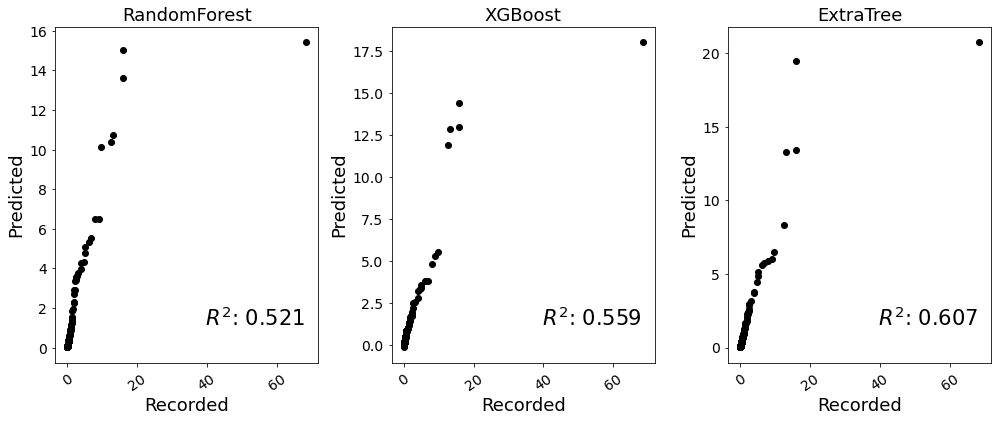

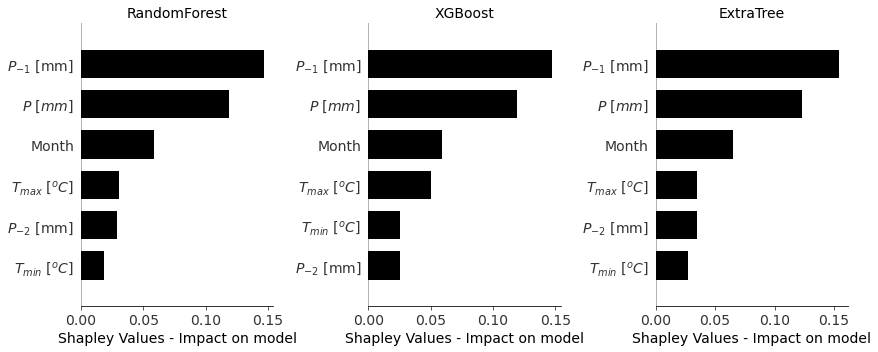

In [31]:
X = df_AI[Features].values
y = df_AI.iloc[:, 6].values  # SM 5cm


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.ravel(),
                                                    test_size=0.3)


pipeline_RF     = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB    = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner       = [pipeline_RF, pipeline_XGB, pipeline_ExTree]

holdem = results(X_train, y_train, X_test, y_test, pipeliner)
print_results(holdem, y_test)


Soil = "3d_SM5"

feature_importance(path_to_save, Soil, pipeliner, X, y, )

### SM_25 ($\theta_{25}$)

+--------------------------------+
|       Training set Score       |
+--------------+----------+------+
|  Algorithm   | R-square | MSE  |
+--------------+----------+------+
| RandomForest |   0.87   | 0.36 |
|   XGBoost    |   1.0    | 0.0  |
|  ExtraTree   |   1.0    | 0.0  |
+--------------+----------+------+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.9    | 0.34 |
|   XGBoost    |   0.87   | 0.39 |
|  ExtraTree   |   0.96   | 0.22 |
+--------------+----------+------+


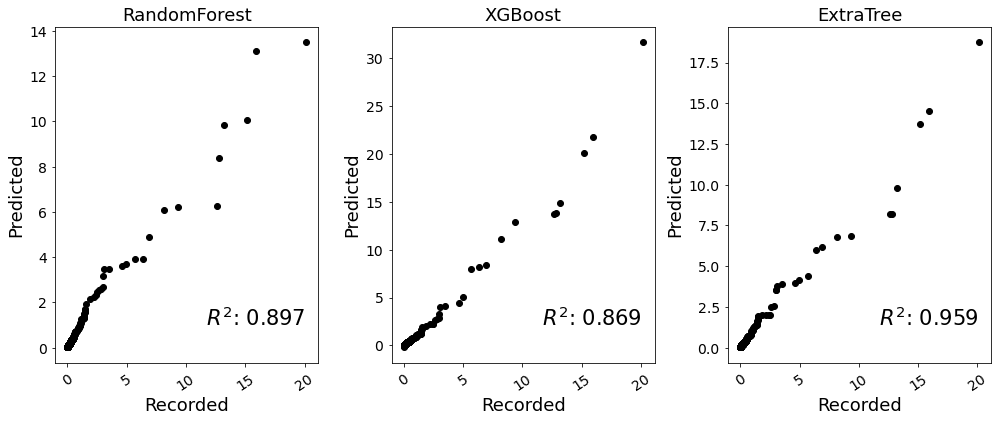

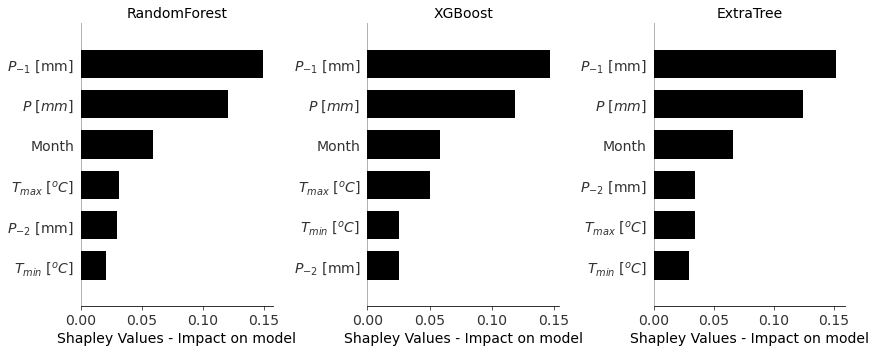

In [32]:
X = df_AI[Features].values
y = df_AI.iloc[:,6].values  # SM 25cm


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.ravel(),
                                                    test_size=0.3)


pipeline_RF     = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB    = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner       = [pipeline_RF, pipeline_XGB, pipeline_ExTree]

holdem = results(X_train, y_train, X_test, y_test, pipeliner)

print_results(holdem, y_test)


Soil = "daily_SM25"

feature_importance(path_to_save, Soil, pipeliner, X, y)

### SM_45 ($\theta_{45}$)

+-------------------------------+
|       Training set Score      |
+--------------+----------+-----+
|  Algorithm   | R-square | MSE |
+--------------+----------+-----+
| RandomForest |   0.9    | 0.0 |
|   XGBoost    |   0.79   | 0.0 |
|  ExtraTree   |   1.0    | 0.0 |
+--------------+----------+-----+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.86   | 0.03 |
|   XGBoost    |   0.88   | 0.03 |
|  ExtraTree   |   0.88   | 0.03 |
+--------------+----------+------+


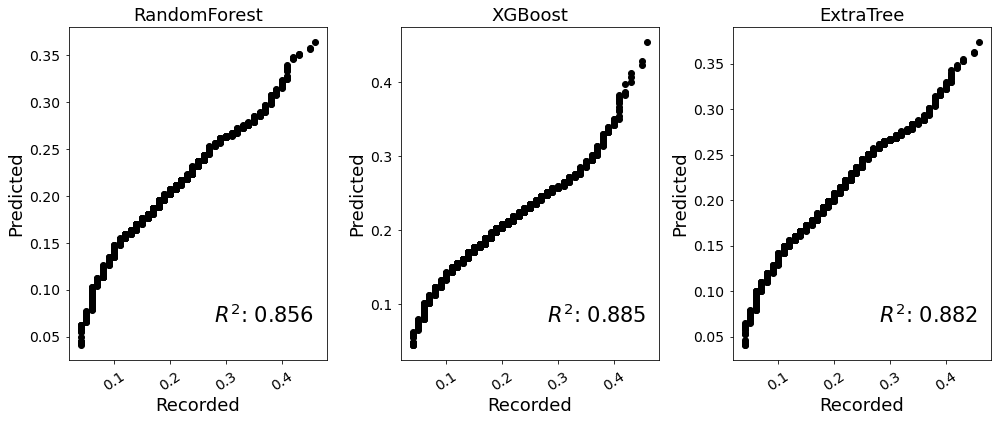

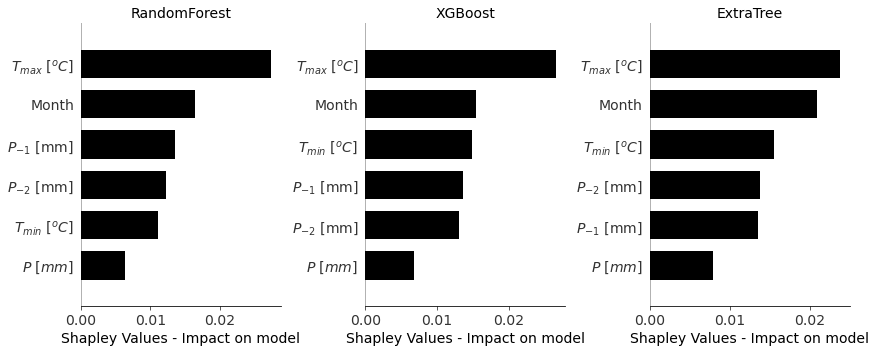

In [34]:
X = df_AI[Features].values
y = df_AI.iloc[:, 7].values  # SM 45cm


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.ravel(),
                                                    test_size=0.3)


pipeline_RF     = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB    = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner       = [pipeline_RF, pipeline_XGB, pipeline_ExTree]

holdem = results(X_train, y_train, X_test, y_test, pipeliner)
print_results(holdem, y_test)


Soil = "daily_SM45"

feature_importance(path_to_save, Soil, pipeliner, X, y)

## 2 Days Rolling average

In [35]:
df_F108.head(3)

TMAX (C)   TMIN (C)  PRCP (mm)       CMS  SM 5 (-)  SM 25 (-)  \
Date                                                                        
2006-12-01  2.294421 -13.299867       4.83  0.096220      0.15       0.18   
2006-12-02  2.699973  -8.611025       0.76  0.108389      0.16       0.18   
2006-12-03  3.238856  -6.122161       0.00  0.098484      0.17       0.19   

            SM 45 (-)  
Date                   
2006-12-01       0.12  
2006-12-02       0.12  
2006-12-03       0.12

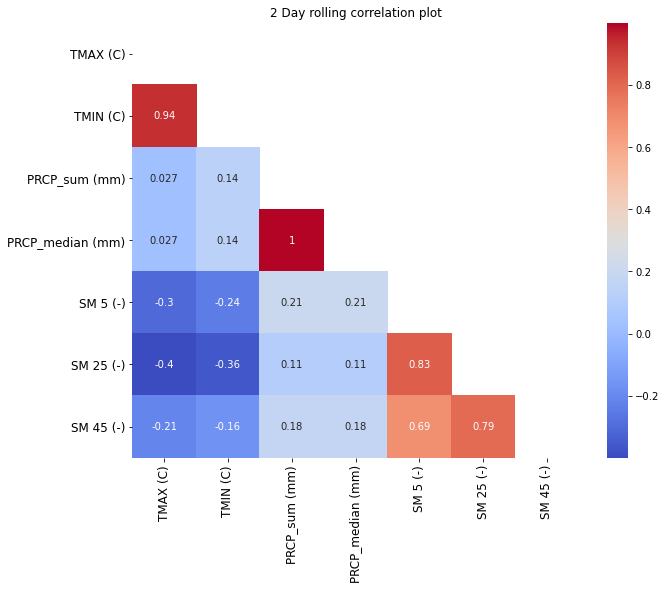

In [37]:
# Resample the temperature
resampled = df_F108[['TMAX (C)', "TMIN (C)"]].resample('2D').median()

# Resample the Precipitation sum and median
resampled["PRCP_sum (mm)"]    = df_F108["PRCP (mm)"].resample('2D').sum()
resampled["PRCP_median (mm)"] = df_F108["PRCP (mm)"].resample('2D').median()

# Resample the discharge sum
#resampled["CMS_sum"] = df_F108["CMS"].resample('2D').sum()
resampled["CMS_median"] = df_F108["CMS"].resample('2D').median()

# Resample the SM
#resampled_SM = df_F108.iloc[:, 4:].resample('2D').mean()
resampled_SM = df_F108.iloc[:, 4:].resample('2D').median()
# The transformed precipitation mean and median

df_F108_resampled = resampled.merge(resampled_SM, on='Date', how="inner")
df_F108_resampled

corr_plot(df_F108_resampled.drop(columns='CMS_median'),
                                         '2 Day rolling correlation plot')


In [39]:
df_AI = df_F108_resampled.drop(columns=["PRCP_median (mm)"])

df_AI.rename( columns = {'TMAX (C)'      : '$T_{max}$ [$^oC$]', 
                         'TMIN (C)'      : '$T_{min}$ [$^oC$]',
                         'PRCP_sum (mm)' : '$P$ [$mm$]'       ,
                         'CMS_median'    : '$Q [$m^3/s$]$'    , 
                         'SM 5 (-)'      : '$\theta_5$ [-]'   ,
                         'SM 25 (-)'     : '$\theta_{25}$ [-]',
                         'SM 45 (-)'     : '$\theta_{45}$ [-]'  }, inplace = True)

#corr_plot(df_AI, 'DF_AI correlation plot')'$P$ [$mm$]'

# Precipitation Lags
df_AI['$P_{-1}$ [mm]'] = df_AI['$P$ [$mm$]'].shift(1)
df_AI['$P_{-2}$ [mm]'] = df_AI['$P$ [$mm$]'].shift(2)

# Sort the columns
month  = df_AI.loc[:, df_AI.columns.str.startswith('M')]
prcp   = df_AI.loc[:, df_AI.columns.str.startswith('$P')]
temp   = df_AI.loc[:, df_AI.columns.str.startswith('$T')]
ds     = df_AI.loc[:, df_AI.columns.str.startswith('$Q')]
sm     = df_AI.loc[:, df_AI.columns.str.startswith('$\t')]

Features = list(df_AI.drop(columns= sm.columns.append(ds.columns)).columns)

# Merge the dataframe
df_AI = month.merge(temp, on='Date').merge(prcp, on='Date').merge(
    ds, on="Date").merge(sm, on="Date").dropna()



### SM_5

+-------------------------------+
|       Training set Score      |
+--------------+----------+-----+
|  Algorithm   | R-square | MSE |
+--------------+----------+-----+
| RandomForest |   0.9    | 0.0 |
|   XGBoost    |   0.91   | 0.0 |
|  ExtraTree   |   1.0    | 0.0 |
+--------------+----------+-----+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.89   | 0.03 |
|   XGBoost    |   0.94   | 0.02 |
|  ExtraTree   |   0.91   | 0.03 |
+--------------+----------+------+


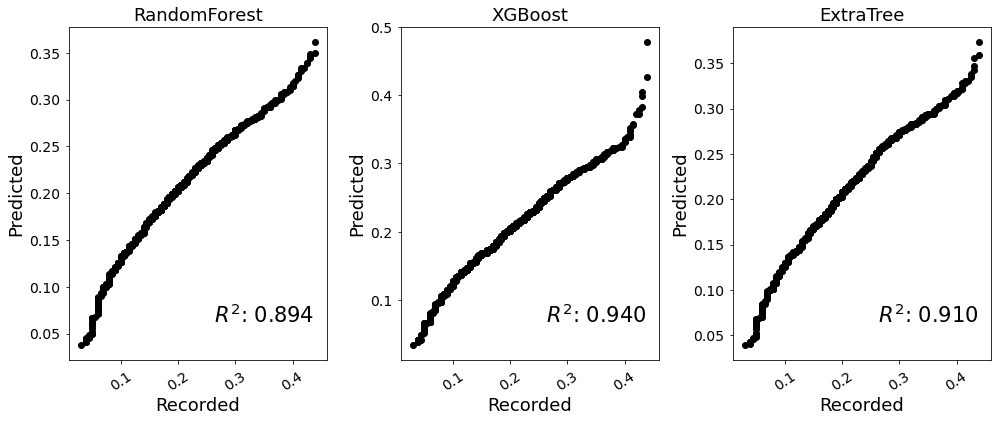

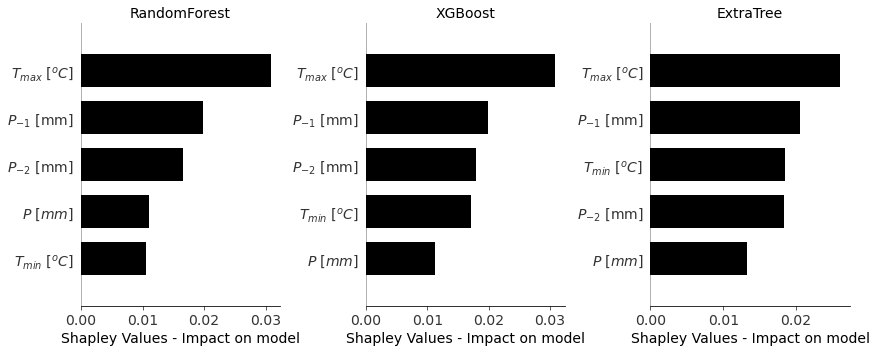

In [40]:
X = df_AI[Features].values
y = df_AI.iloc[:, 6].values  # SM 5cm


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.ravel(),
                                                    test_size=0.3)


pipeline_RF     = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB    = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner       = [pipeline_RF, pipeline_XGB, pipeline_ExTree]

holdem = results(X_train, y_train, X_test, y_test, pipeliner)
print_results(holdem, y_test)


Soil = "2d_SM5"

feature_importance(path_to_save, Soil, pipeliner, X, y, )

### SM_25

+-------------------------------+
|       Training set Score      |
+--------------+----------+-----+
|  Algorithm   | R-square | MSE |
+--------------+----------+-----+
| RandomForest |   0.9    | 0.0 |
|   XGBoost    |   0.91   | 0.0 |
|  ExtraTree   |   1.0    | 0.0 |
+--------------+----------+-----+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.85   | 0.02 |
|   XGBoost    |   0.9    | 0.02 |
|  ExtraTree   |   0.87   | 0.02 |
+--------------+----------+------+


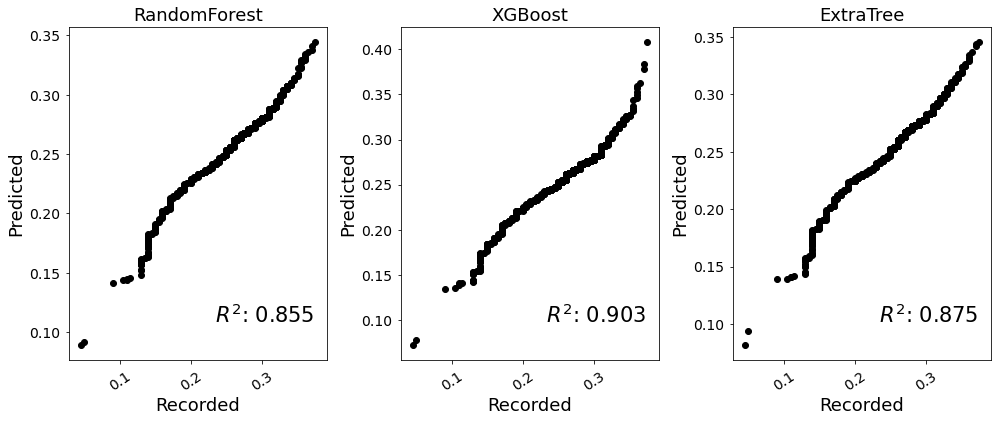

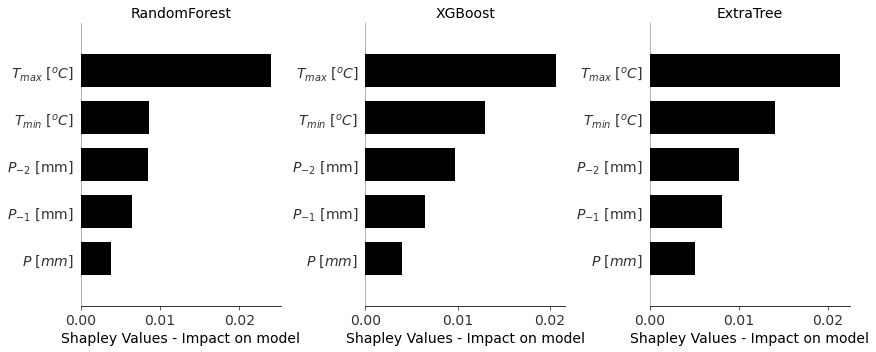

In [41]:
X = df_AI[Features].values
y = df_AI.iloc[:, 7].values  # SM 25cm


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.ravel(),
                                                    test_size=0.3)


pipeline_RF     = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB    = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner       = [pipeline_RF, pipeline_XGB, pipeline_ExTree]

holdem = results(X_train, y_train, X_test, y_test, pipeliner)
print_results(holdem, y_test)




Soil = "2d_SM25"

feature_importance(path_to_save, Soil, pipeliner, X, y)


### SM_45

+-------------------------------+
|       Training set Score      |
+--------------+----------+-----+
|  Algorithm   | R-square | MSE |
+--------------+----------+-----+
| RandomForest |   0.88   | 0.0 |
|   XGBoost    |   0.86   | 0.0 |
|  ExtraTree   |   1.0    | 0.0 |
+--------------+----------+-----+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.78   | 0.02 |
|   XGBoost    |   0.84   | 0.02 |
|  ExtraTree   |   0.82   | 0.02 |
+--------------+----------+------+


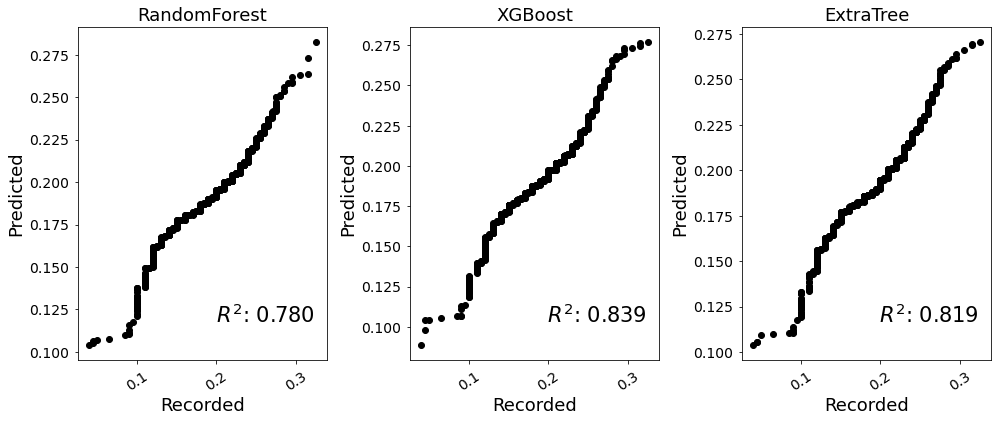

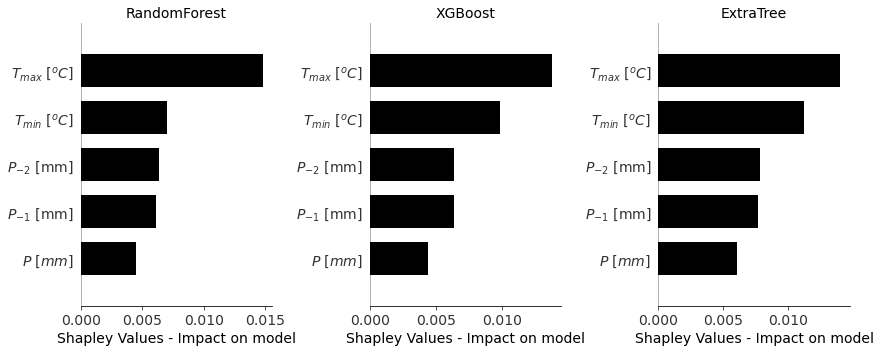

In [42]:
X = df_AI[Features].values
y = df_AI.iloc[:, 8].values  # SM 45cm


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.ravel(),
                                                    test_size=0.3)


pipeline_RF     = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB    = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner       = [pipeline_RF, pipeline_XGB, pipeline_ExTree]

holdem = results(X_train, y_train, X_test, y_test, pipeliner)
print_results(holdem, y_test)


Soil = "2d_SM45"

feature_importance(path_to_save, Soil, pipeliner,X ,y,)


## 3 Days Rolling average

In [43]:
df_F108.head(3)

TMAX (C)   TMIN (C)  PRCP (mm)       CMS  SM 5 (-)  SM 25 (-)  \
Date                                                                        
2006-12-01  2.294421 -13.299867       4.83  0.096220      0.15       0.18   
2006-12-02  2.699973  -8.611025       0.76  0.108389      0.16       0.18   
2006-12-03  3.238856  -6.122161       0.00  0.098484      0.17       0.19   

            SM 45 (-)  
Date                   
2006-12-01       0.12  
2006-12-02       0.12  
2006-12-03       0.12

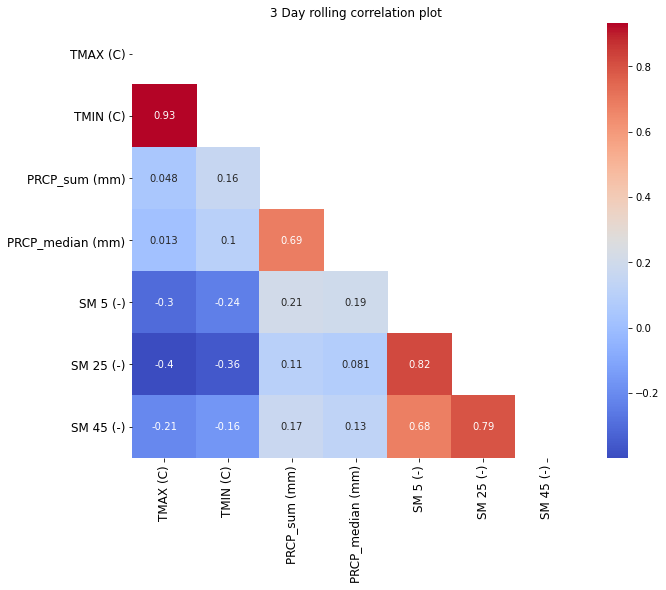

In [61]:
# Resample the temperature
resampled = df_F108[['TMAX (C)', "TMIN (C)"]].resample('3D').median()

# Resample the Precipitation sum and median
resampled["PRCP_sum (mm)"]    = df_F108["PRCP (mm)"].resample('3D').sum()
resampled["PRCP_median (mm)"] = df_F108["PRCP (mm)"].resample('3D').median()

# Resample the discharge sum
#resampled["CMS_sum"] = df_F108["CMS"].resample('3D').sum()
resampled["CMS_median"] = df_F108["CMS"].resample('3D').median()

# Resample the SM
#resampled_SM = df_F108.iloc[:, 4:].resample('3D').mean()
resampled_SM = df_F108.iloc[:, 4:].resample('3D').median()
# The transformed precipitation mean and median

df_F108_resampled = resampled.merge(resampled_SM, on='Date', how="inner")
df_F108_resampled

corr_plot(df_F108_resampled.drop(columns='CMS_median'),
                                         '3 Day rolling correlation plot')


In [62]:
df_AI = df_F108_resampled.drop(columns=["PRCP_median (mm)"])

df_AI.rename( columns = {'TMAX (C)'      : '$T_{max}$ [$^oC$]', 
                         'TMIN (C)'      : '$T_{min}$ [$^oC$]',
                         'PRCP_sum (mm)' : '$P$ [$mm$]'       ,
                         'CMS_median'    : '$Q [$m^3/s$]$'    , 
                         'SM 5 (-)'      : '$\theta_5$ [-]'   ,
                         'SM 25 (-)'     : '$\theta_{25}$ [-]',
                         'SM 45 (-)'     : '$\theta_{45}$ [-]'  }, inplace = True)

#corr_plot(df_AI, 'DF_AI correlation plot')'$P$ [$mm$]'

# Precipitation Lags
df_AI['$P_{-1}$ [mm]'] = df_AI['$P$ [$mm$]'].shift(1)
df_AI['$P_{-2}$ [mm]'] = df_AI['$P$ [$mm$]'].shift(2)

# Sort the columns
month  = df_AI.loc[:, df_AI.columns.str.startswith('M')]
prcp   = df_AI.loc[:, df_AI.columns.str.startswith('$P')]
temp   = df_AI.loc[:, df_AI.columns.str.startswith('$T')]
ds     = df_AI.loc[:, df_AI.columns.str.startswith('$Q')]
sm     = df_AI.loc[:, df_AI.columns.str.startswith('$\t')]

Features = list(df_AI.drop(columns=list(sm.columns.append(ds.columns))).columns)

# Merge the dataframe
df_AI = month.merge(temp, on='Date').merge(prcp, on='Date').merge(
    ds, on="Date").merge(sm, on="Date").dropna()


df_AI


$T_{max}$ [$^oC$]  $T_{min}$ [$^oC$]  $P$ [$mm$]  $P_{-1}$ [mm]  \
Date                                                                          
2006-12-07           5.977718          -7.866588        0.00           0.00   
2006-12-10          17.310938           2.616640        0.00           0.00   
2006-12-13          18.722035          -0.261108        0.00           0.00   
2006-12-16          13.038759           1.833315        3.30           0.00   
2006-12-19           7.372148           1.494430       33.53           3.30   
...                       ...                ...         ...            ...   
2020-12-17          10.199898          -0.844436        5.33           7.37   
2020-12-20          16.827610           0.061110        0.00           5.33   
2020-12-23          14.577632          -4.588843        0.00           0.00   
2020-12-26          17.427604           1.688872        0.00           0.00   
2020-12-29           4.911062          -0.694438       39.12           0.00   

            $P_{-2}$ [mm]  $Q [$m^3/s$]$  $\theta_5$ [-]  $\theta_{25}$ [-]  \
Date                                                                          
2006-12-07           5.59       0.086032            0.18               0.26   
2006-12-10           0.00       0.086032            0.17               0.25   
2006-12-13           0.00       0.085749            0.16               0.25   
2006-12-16           0.00       0.085183            0.15               0.25   
2006-12-19           0.00       0.142915            0.21               0.28   
...                   ...            ...             ...                ...   
2020-12-17           3.30       0.157914            0.28               0.31   
2020-12-20           7.37       0.147726            0.27               0.31   
2020-12-23           5.33       0.128482            0.26               0.30   
2020-12-26           0.00       0.135557            0.25               0.30   
2020-12-29           0.00       0.331110            0.31               0.32   

            $\theta_{45}$ [-]  
Date                           
2006-12-07               0.12  
2006-12-10               0.12  
2006-12-13               0.13  
2006-12-16               0.13  
2006-12-19               0.19  
...                       ...  
2020-12-17               0.25  
2020-12-20               0.25  
2020-12-23               0.24  
2020-12-26               0.24  
2020-12-29               0.27  

[1713 rows x 9 columns]

### SM_5

+-------------------------------+
|       Training set Score      |
+--------------+----------+-----+
|  Algorithm   | R-square | MSE |
+--------------+----------+-----+
| RandomForest |   0.91   | 0.0 |
|   XGBoost    |   0.96   | 0.0 |
|  ExtraTree   |   1.0    | 0.0 |
+--------------+----------+-----+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.87   | 0.03 |
|   XGBoost    |   0.93   | 0.02 |
|  ExtraTree   |   0.88   | 0.03 |
+--------------+----------+------+


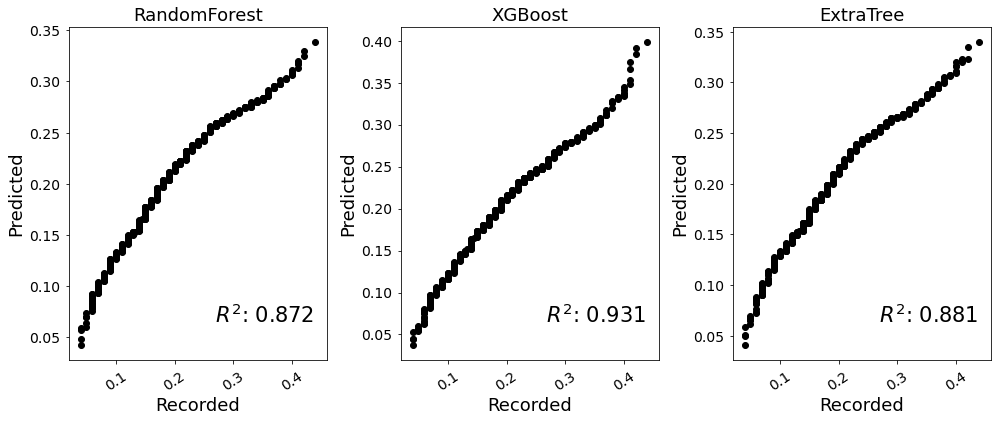

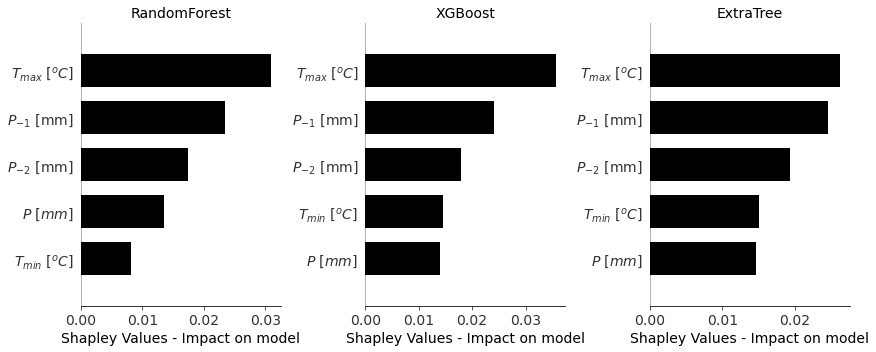

In [63]:
X = df_AI[Features].values
y = df_AI.iloc[:, 6].values  # SM 5cm


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.ravel(),
                                                    test_size=0.3)


pipeline_RF     = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB    = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner       = [pipeline_RF, pipeline_XGB, pipeline_ExTree]

holdem = results(X_train, y_train, X_test, y_test, pipeliner)
print_results(holdem, y_test)


Soil = "3d_SM5"

feature_importance(path_to_save, Soil, pipeliner, X, y, )


### SM_25

+-------------------------------+
|       Training set Score      |
+--------------+----------+-----+
|  Algorithm   | R-square | MSE |
+--------------+----------+-----+
| RandomForest |   0.9    | 0.0 |
|   XGBoost    |   0.96   | 0.0 |
|  ExtraTree   |   1.0    | 0.0 |
+--------------+----------+-----+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.88   | 0.02 |
|   XGBoost    |   0.93   | 0.02 |
|  ExtraTree   |   0.9    | 0.02 |
+--------------+----------+------+


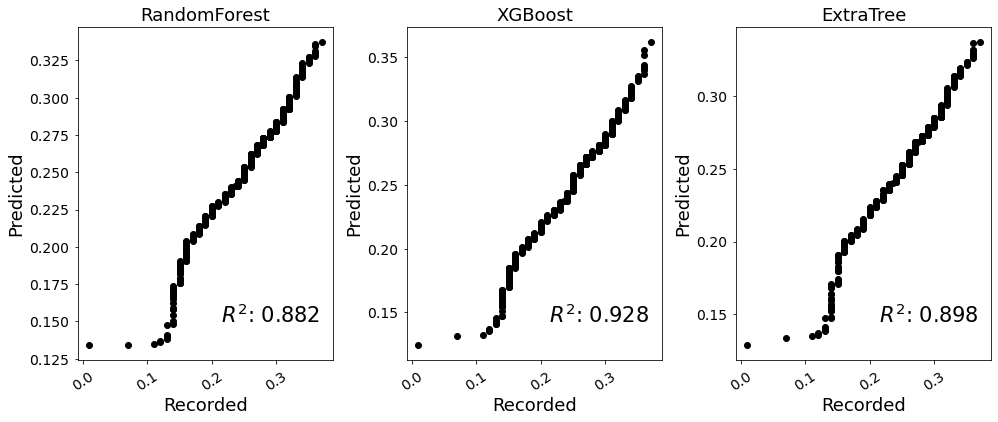

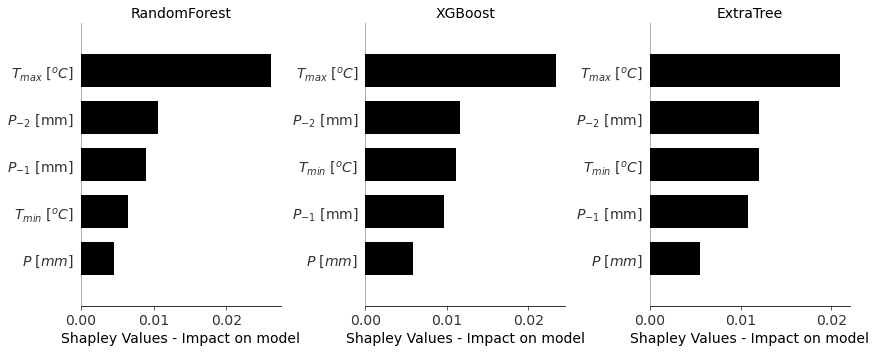

In [64]:
X = df_AI[Features].values
y = df_AI.iloc[:, 7].values  # SM 5cm


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.ravel(),
                                                    test_size=0.3)


pipeline_RF     = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB    = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner       = [pipeline_RF, pipeline_XGB, pipeline_ExTree]

holdem = results(X_train, y_train, X_test, y_test, pipeliner)
print_results(holdem, y_test)




Soil = "3d_SM25"

feature_importance(path_to_save, Soil, pipeliner, X, y)


### SM_45

+-------------------------------+
|       Training set Score      |
+--------------+----------+-----+
|  Algorithm   | R-square | MSE |
+--------------+----------+-----+
| RandomForest |   0.89   | 0.0 |
|   XGBoost    |   0.95   | 0.0 |
|  ExtraTree   |   1.0    | 0.0 |
+--------------+----------+-----+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.78   | 0.02 |
|   XGBoost    |   0.86   | 0.02 |
|  ExtraTree   |   0.8    | 0.02 |
+--------------+----------+------+


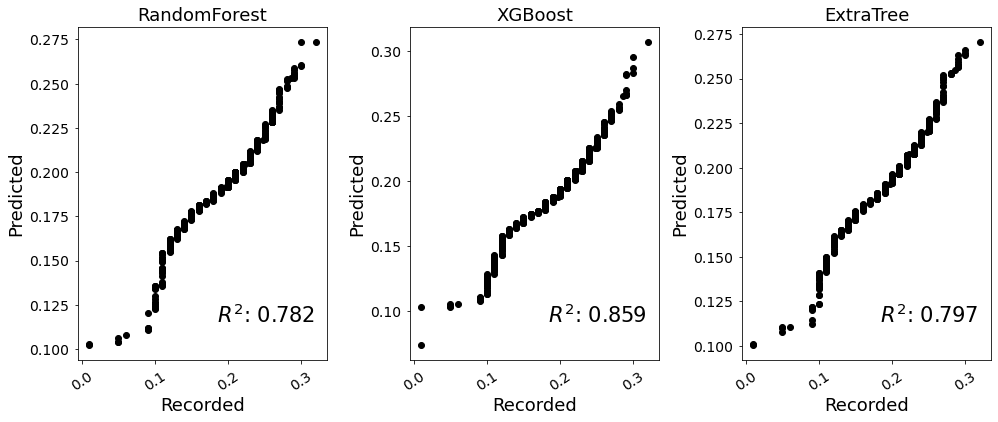

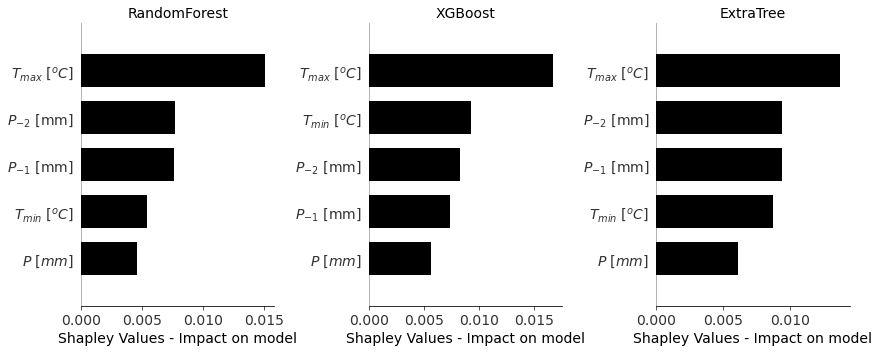

In [65]:
X = df_AI[Features].values
y = df_AI.iloc[:, 8].values  # SM 45cm


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.ravel(),
                                                    test_size=0.3)


pipeline_RF     = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB    = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner       = [pipeline_RF, pipeline_XGB, pipeline_ExTree]

holdem = results(X_train, y_train, X_test, y_test, pipeliner)
print_results(holdem, y_test)


Soil = "3d_SM45"

feature_importance(path_to_save, Soil, pipeliner,X ,y,)


## Weekly

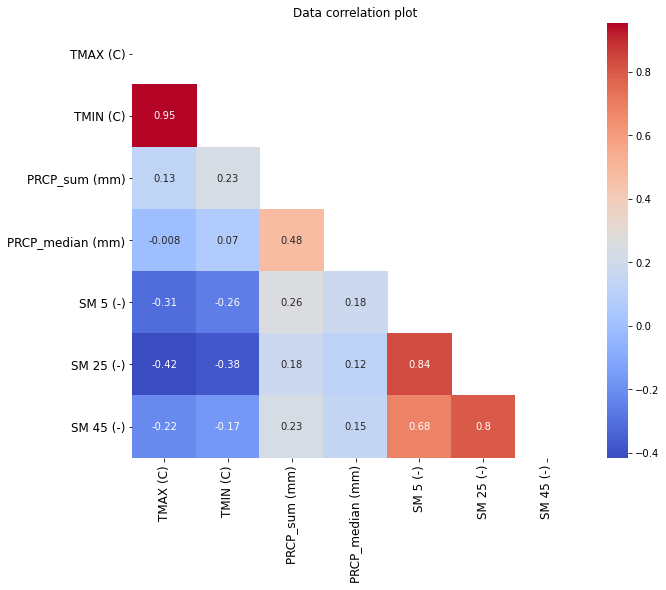

In [66]:
# Resample the temperature
resampled = df_F108[['TMAX (C)', "TMIN (C)"]].resample('W').median()

# Resample the Precipitation sum and median
resampled["PRCP_sum (mm)"]    = df_F108["PRCP (mm)"].resample('W').sum()
resampled["PRCP_median (mm)"] = df_F108["PRCP (mm)"].resample('W').median()

# Resample the discharge sum
#resampled["CMS_sum"]    = df_F108["CMS"].resample('W').sum()
resampled["CMS_median"] = df_F108["CMS"].resample('W').median()

# Resample the SM
# resampled_SM = df_F108.iloc[:, 4:].resample('W').mean()
resampled_SM = df_F108.iloc[:, 4:].resample('W').median()
# The transformed precipitation mean and median

df_F108_resampled = resampled.merge(resampled_SM, on='Date', how="inner")


corr_plot(df_F108_resampled.drop(columns='CMS_median'), 'Data correlation plot')



The pearson correlation shows that the resampled weekly mean PRCP (mm) has a higher correlation with other features than the median

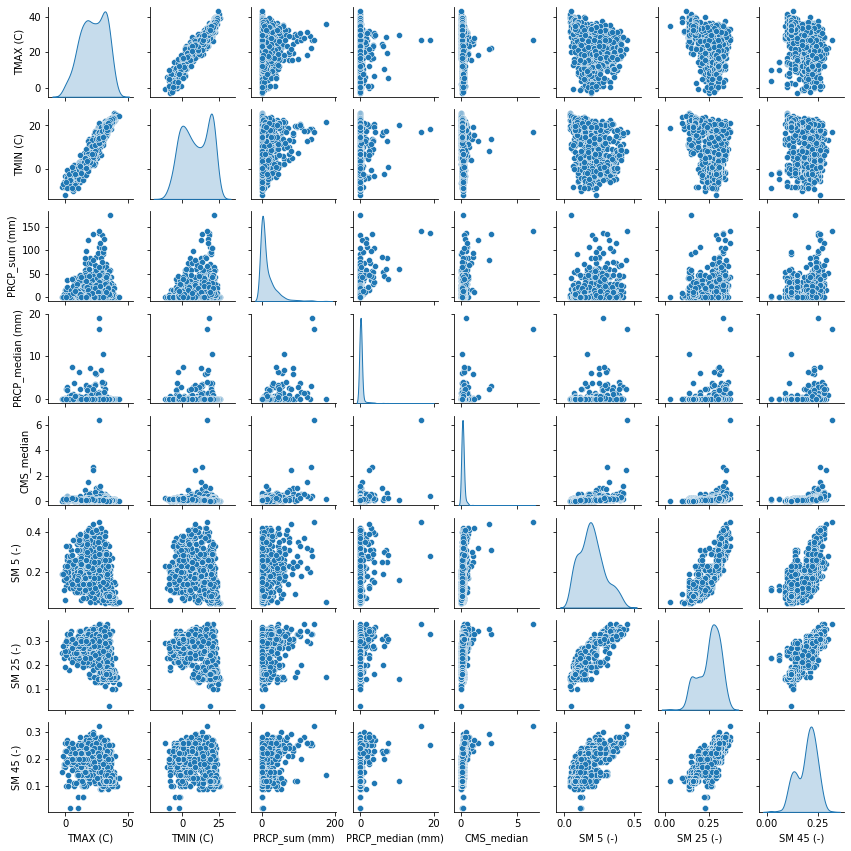

In [67]:
sns.pairplot(df_F108_resampled, diag_kind='kde', height=1.5)

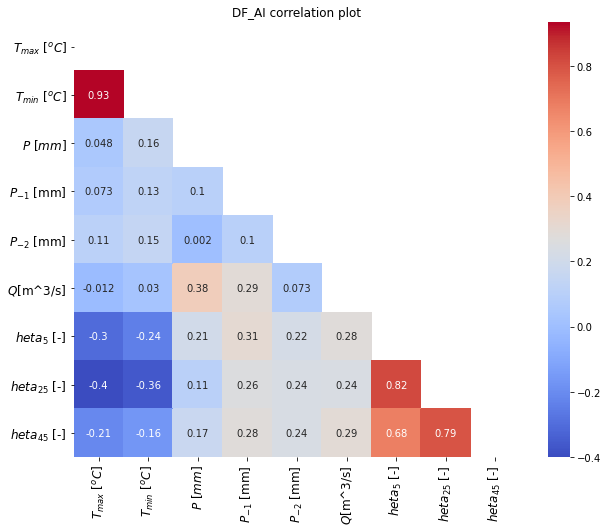

In [68]:
corr_plot(df_AI, 'DF_AI correlation plot')

In [69]:
df_F108_resampled.head(3)

TMAX (C)  TMIN (C)  PRCP_sum (mm)  PRCP_median (mm)  CMS_median  \
Date                                                                           
2006-12-03   2.699973 -8.611025           5.59              0.76    0.098484   
2006-12-10  11.177666 -2.799972           0.00              0.00    0.086315   
2006-12-17  18.577592  1.638872           0.00              0.00    0.085749   

            SM 5 (-)  SM 25 (-)  SM 45 (-)  
Date                                        
2006-12-03      0.16       0.18       0.12  
2006-12-10      0.19       0.26       0.12  
2006-12-17      0.16       0.25       0.13

In [70]:
df_AI = df_F108_resampled.drop(columns=["PRCP_median (mm)"])

df_AI.rename( columns = {'TMAX (C)'      : '$T_{max}$ [$^oC$]', 
                         'TMIN (C)'      : '$T_{min}$ [$^oC$]',
                         'PRCP_sum (mm)' : '$P$ [$mm$]'       ,
                         'CMS_median'    : '$Q [$m^3/s$]$'    , 
                         'SM 5 (-)'      : '$\theta_5$ [-]'   ,
                         'SM 25 (-)'     : '$\theta_{25}$ [-]',
                         'SM 45 (-)'     : '$\theta_{45}$ [-]'  }, inplace = True)

#corr_plot(df_AI, 'DF_AI correlation plot')'$P$ [$mm$]'

# Precipitation Lags
df_AI['$P_{-1}$ [mm]'] = df_AI['$P$ [$mm$]'].shift(1)
df_AI['$P_{-2}$ [mm]'] = df_AI['$P$ [$mm$]'].shift(2)

# Sort the columns
month  = df_AI.loc[:, df_AI.columns.str.startswith('M')]
prcp   = df_AI.loc[:, df_AI.columns.str.startswith('$P')]
temp   = df_AI.loc[:, df_AI.columns.str.startswith('$T')]
ds     = df_AI.loc[:, df_AI.columns.str.startswith('$Q')]
sm     = df_AI.loc[:, df_AI.columns.str.startswith('$\t')]

Features = list(df_AI.drop(columns=list(sm.columns.append(ds.columns))).columns)

# Merge the dataframe
df_AI = month.merge(temp, on='Date').merge(prcp, on='Date').merge(ds, on="Date").merge(sm, on="Date").dropna()


df_AI


$T_{max}$ [$^oC$]  $T_{min}$ [$^oC$]  $P$ [$mm$]  $P_{-1}$ [mm]  \
Date                                                                          
2006-12-17          18.577592           1.638872        0.00           0.00   
2006-12-24           8.388805          -0.594438       36.83           0.00   
2006-12-31          12.799872           0.633327        8.38          36.83   
2007-01-07           8.438804          -1.727761        0.25           8.38   
2007-01-14          12.772094          -4.205514        0.00           0.25   
...                       ...                ...         ...            ...   
2020-12-06          12.549874          -2.299977        0.76           6.09   
2020-12-13          18.377594          -1.299987        3.30           0.76   
2020-12-20           7.838811          -2.638863       12.70           3.30   
2020-12-27          16.827610           0.061110        0.00          12.70   
2021-01-03           5.444390           0.497217       39.12           0.00   

            $P_{-2}$ [mm]  $Q [$m^3/s$]$  $\theta_5$ [-]  $\theta_{25}$ [-]  \
Date                                                                          
2006-12-17           5.59       0.085749           0.160               0.25   
2006-12-24           0.00       0.101314           0.190               0.27   
2006-12-31           0.00       0.095088           0.180               0.26   
2007-01-07          36.83       0.092824           0.180               0.26   
2007-01-14           8.38       0.093673           0.160               0.25   
...                   ...            ...             ...                ...   
2020-12-06           8.64       0.134991           0.240               0.30   
2020-12-13           6.09       0.129614           0.230               0.29   
2020-12-20           0.76       0.161310           0.260               0.29   
2020-12-27           3.30       0.132444           0.260               0.30   
2021-01-03          12.70       0.242390           0.285               0.31   

            $\theta_{45}$ [-]  
Date                           
2006-12-17               0.13  
2006-12-24               0.20  
2006-12-31               0.19  
2007-01-07               0.19  
2007-01-14               0.19  
...                       ...  
2020-12-06               0.22  
2020-12-13               0.22  
2020-12-20               0.22  
2020-12-27               0.24  
2021-01-03               0.26  

[734 rows x 9 columns]

### SM_5cm

+-------------------------------+
|       Training set Score      |
+--------------+----------+-----+
|  Algorithm   | R-square | MSE |
+--------------+----------+-----+
| RandomForest |   0.91   | 0.0 |
|   XGBoost    |   1.0    | 0.0 |
|  ExtraTree   |   1.0    | 0.0 |
+--------------+----------+-----+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.81   | 0.04 |
|   XGBoost    |   0.9    | 0.03 |
|  ExtraTree   |   0.8    | 0.04 |
+--------------+----------+------+


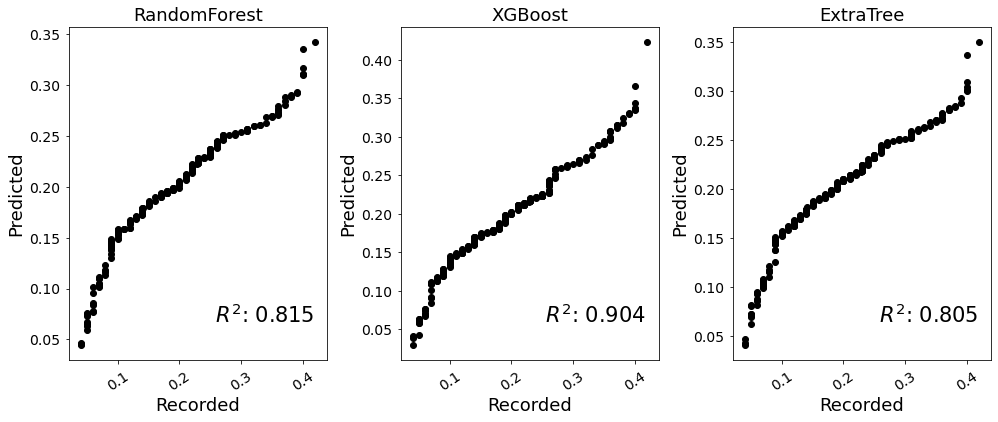

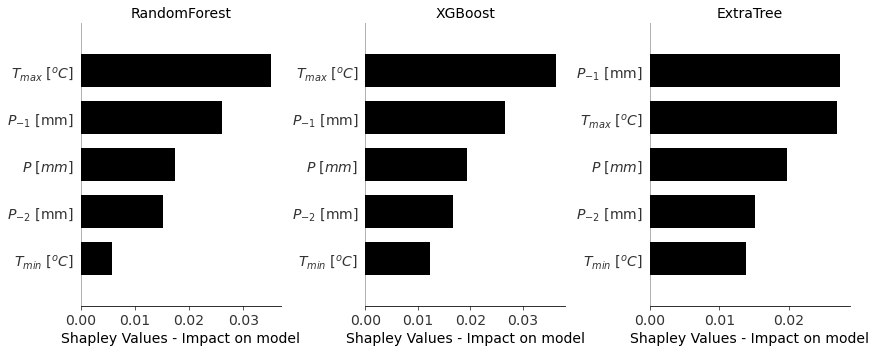

In [71]:
X = df_AI[Features].values
y = df_AI.iloc[:, -3].values # SM 5cm


X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y.ravel(),
                                                    test_size=0.3,
                                                    )
                                                    
pipeline_RF = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner = [pipeline_RF, pipeline_XGB, pipeline_ExTree]

#model = pipeline_RF.fit(X_train, y_train)


holdem = results(X_train, y_train, X_test, y_test, pipeliner)
print_results(holdem, y_test)


Soil = "week_SM5"

feature_importance(path_to_save, Soil, pipeliner, X, y, )


 Randomforest gives the best results for the test result although performs the least on training 
 while the RMSE is equal for both the XGBoost and the Extratree

### SM_25cm

+-------------------------------+
|       Training set Score      |
+--------------+----------+-----+
|  Algorithm   | R-square | MSE |
+--------------+----------+-----+
| RandomForest |   0.93   | 0.0 |
|   XGBoost    |   1.0    | 0.0 |
|  ExtraTree   |   1.0    | 0.0 |
+--------------+----------+-----+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.93   | 0.02 |
|   XGBoost    |   0.97   | 0.01 |
|  ExtraTree   |   0.92   | 0.02 |
+--------------+----------+------+


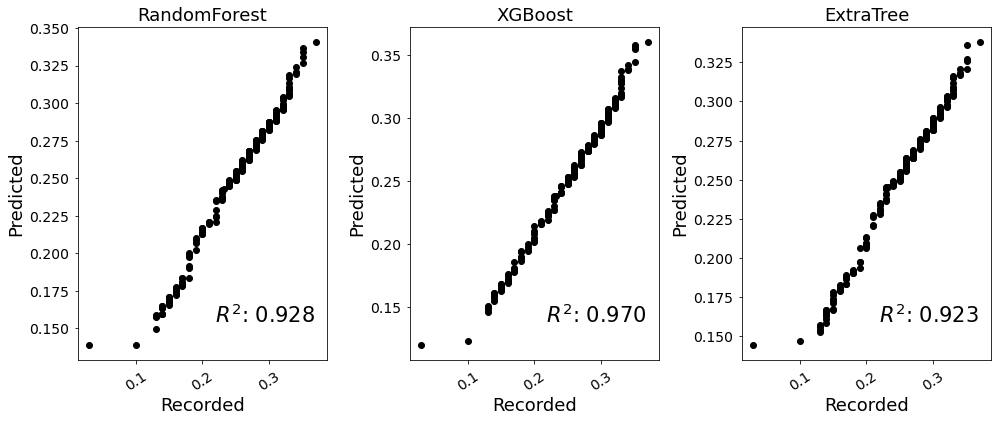

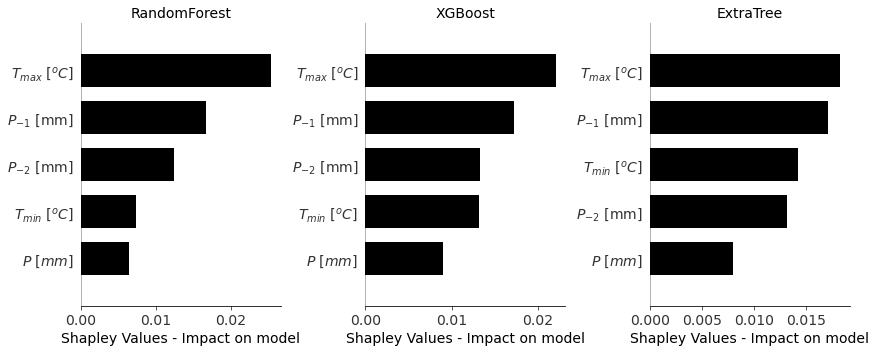

In [72]:
X = df_AI[Features].values
y = df_AI.iloc[:, -2].values # SM 25cm


X_train, X_test, y_train, y_test = train_test_split( X, 
                                                    y.ravel(),
                                                     test_size=0.3)
                                                     

pipeline_RF = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner = [pipeline_RF, pipeline_XGB, pipeline_ExTree]


holdem = results(X_train, y_train, X_test, y_test, pipeliner)
print_results(holdem, y_test)


Soil = "week_SM25"

feature_importance(path_to_save, Soil, pipeliner, X, y, )


### SM_45cm

+-------------------------------+
|       Training set Score      |
+--------------+----------+-----+
|  Algorithm   | R-square | MSE |
+--------------+----------+-----+
| RandomForest |   0.91   | 0.0 |
|   XGBoost    |   1.0    | 0.0 |
|  ExtraTree   |   1.0    | 0.0 |
+--------------+----------+-----+
+--------------------------------+
|         Test set Score         |
+--------------+----------+------+
|  Algorithm   | R-square | RMSE |
+--------------+----------+------+
| RandomForest |   0.78   | 0.02 |
|   XGBoost    |   0.86   | 0.02 |
|  ExtraTree   |   0.79   | 0.02 |
+--------------+----------+------+


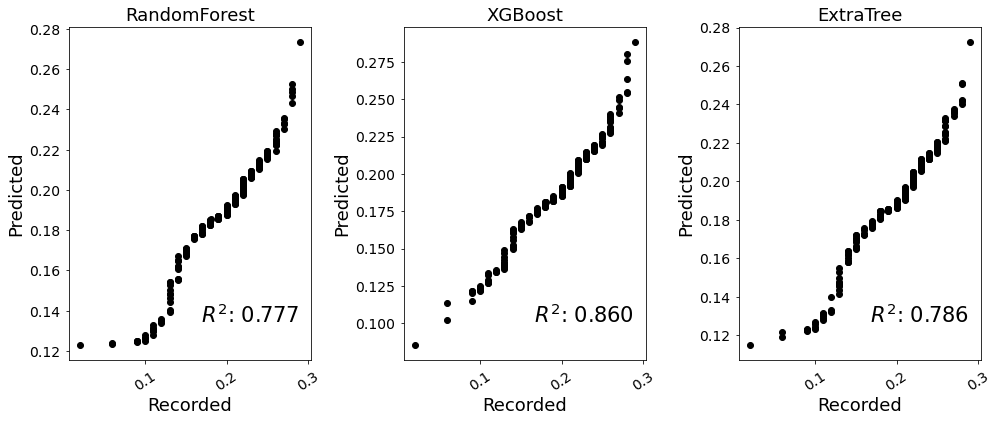

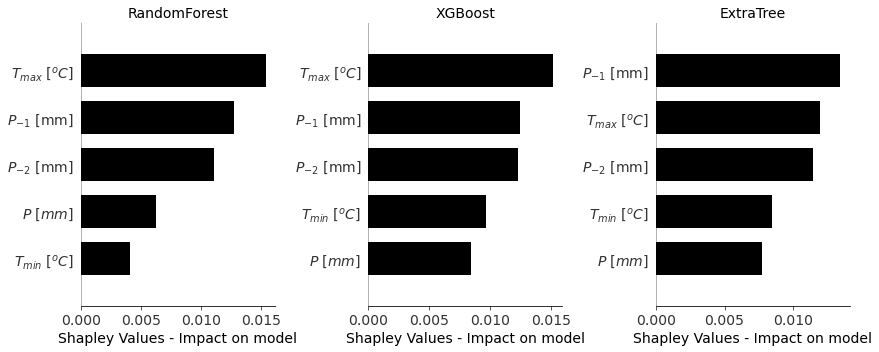

In [73]:
X = df_AI[Features].values
y = df_AI.iloc[:, -1].values # SM 45cm


X_train, X_test, y_train, y_test = train_test_split( X, 
                                                    y.ravel(),
                                                     test_size=0.3)
                                                     

pipeline_RF = Pipeline([('RandomForest', RandomForestRegressor())])
pipeline_XGB = Pipeline([('XGBoost', XGBRegressor())])
pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
pipeliner = [pipeline_RF, pipeline_XGB, pipeline_ExTree]


#model = pipeline_RF.fit(X_train, y_train)


holdem = results(X_train, y_train, X_test, y_test, pipeliner)
print_results(holdem, y_test)


Soil = "week_SM45"

feature_importance(path_to_save, Soil, pipeliner, X, y, )


## Shapley Analysis

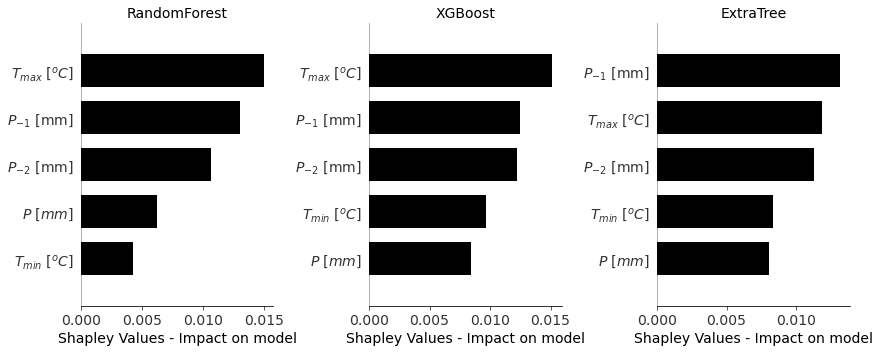

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True, figsize=(32, 5))
gs = gridspec.GridSpec(1, 3)
keep = {}
for count, model in enumerate(pipeliner):
    Modeled = model[0].fit(X, y.ravel())
    explainer = shap.TreeExplainer(Modeled)
    shap_values = explainer.shap_values(X)
    ax = fig.add_subplot(gs[0, count])
    shap.summary_plot(shap_values, X, Features, show=False,
                      plot_type="bar", color="black", plot_size=(12, 5))
    plt.xlabel('Shapley Values - Impact on model', fontsize=14)
    plt.tick_params(labelsize=14)
    # plt.ylabel(labelsize=16)
    plt.tight_layout(pad=1.2)
    plt.title(model.steps[0][0], fontsize=14)
    keep[model.steps[0][0]] = shap_values
    fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()

plt.savefig(path_to_save+r'/Histogram-importance.jpg',
            format='jpeg', dpi=300, bbox_inches='tight')
plt.show()


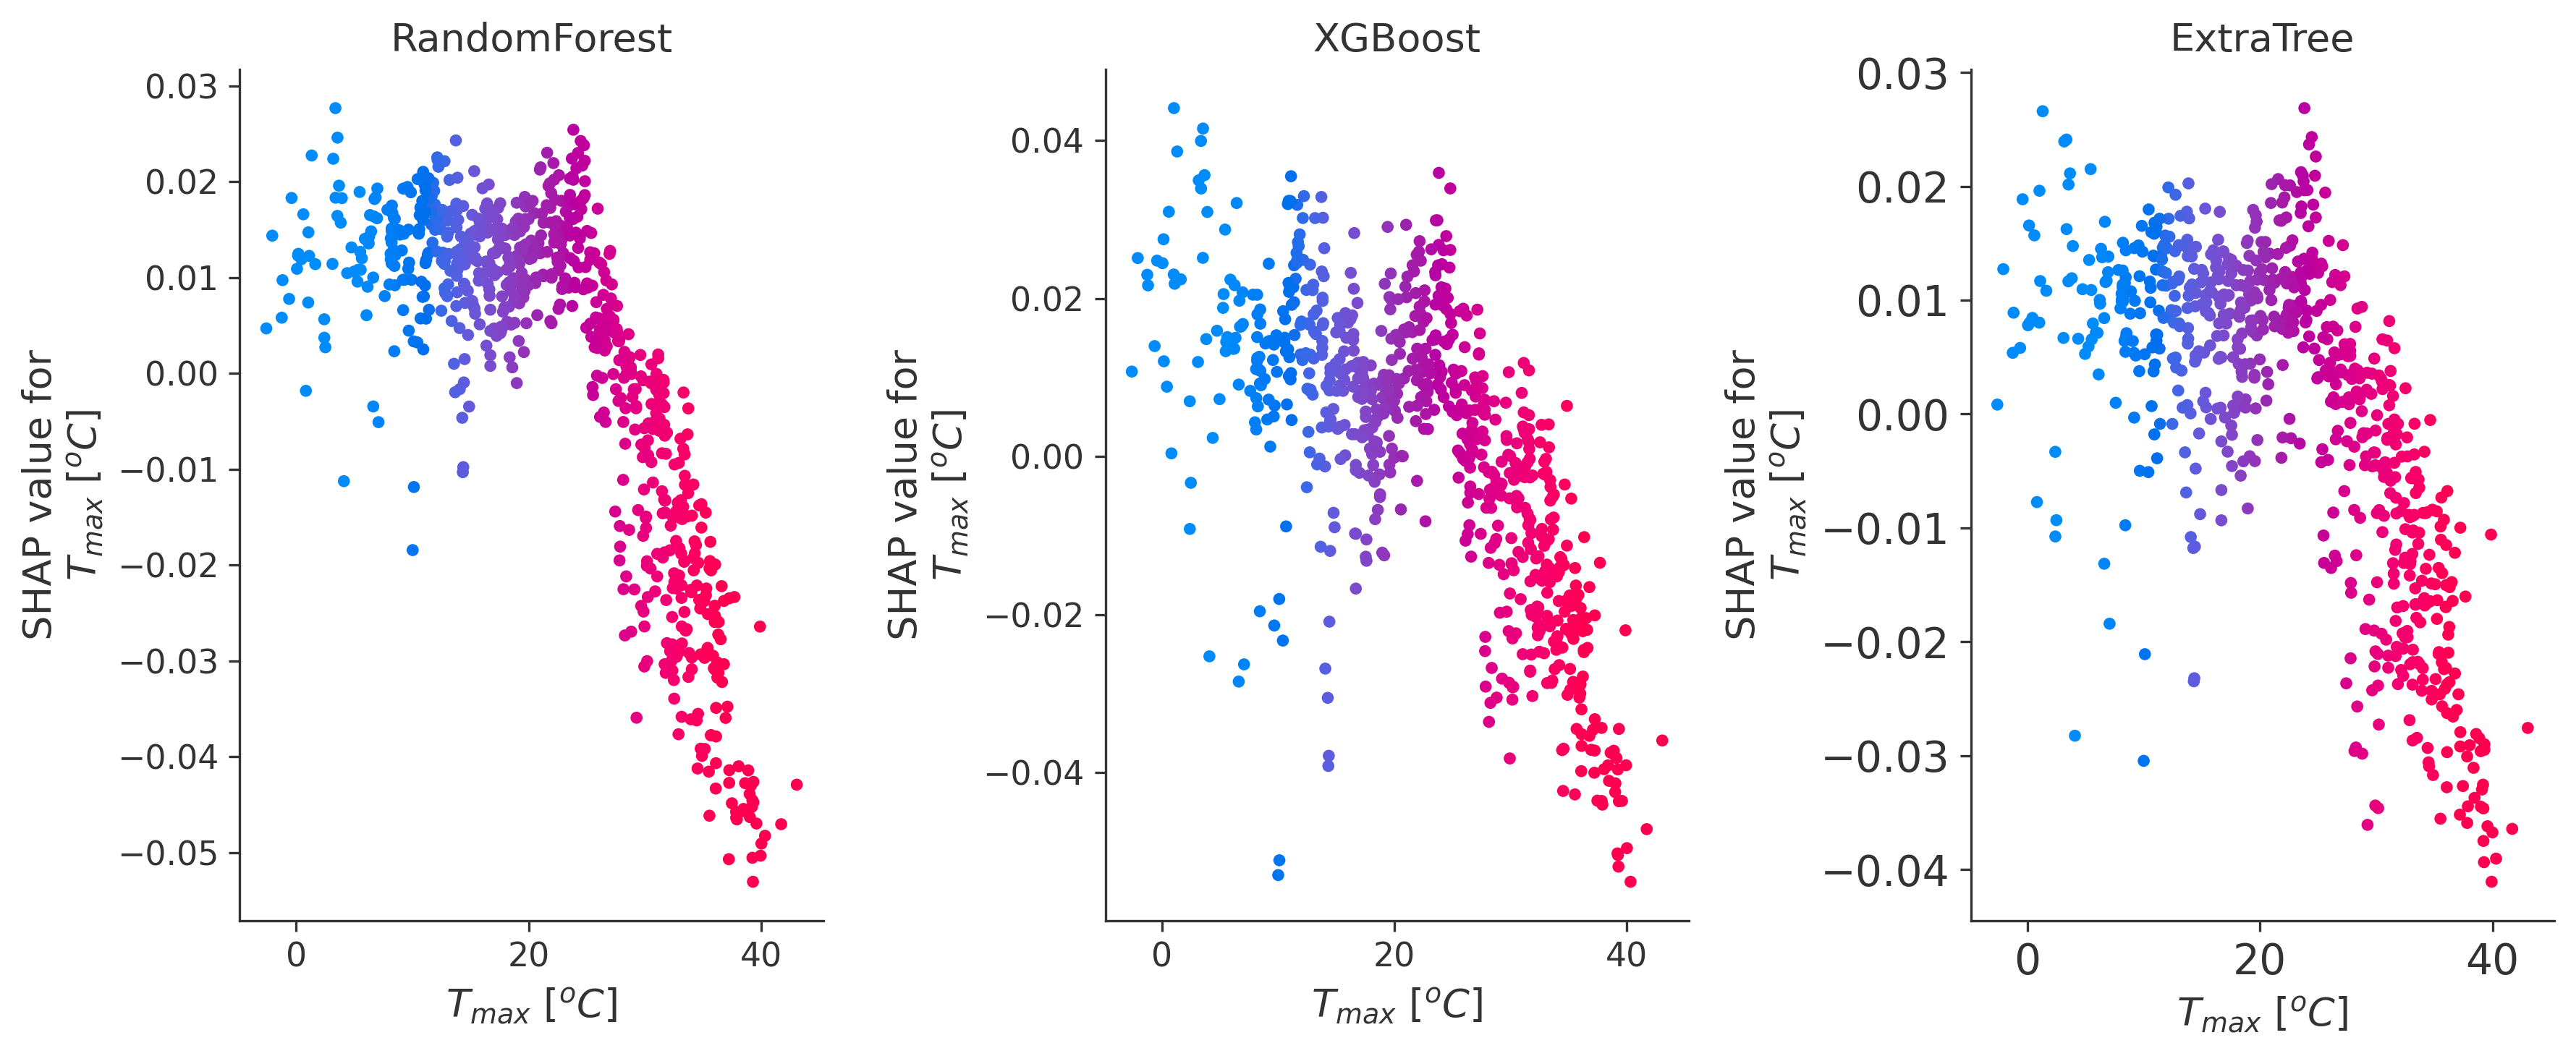

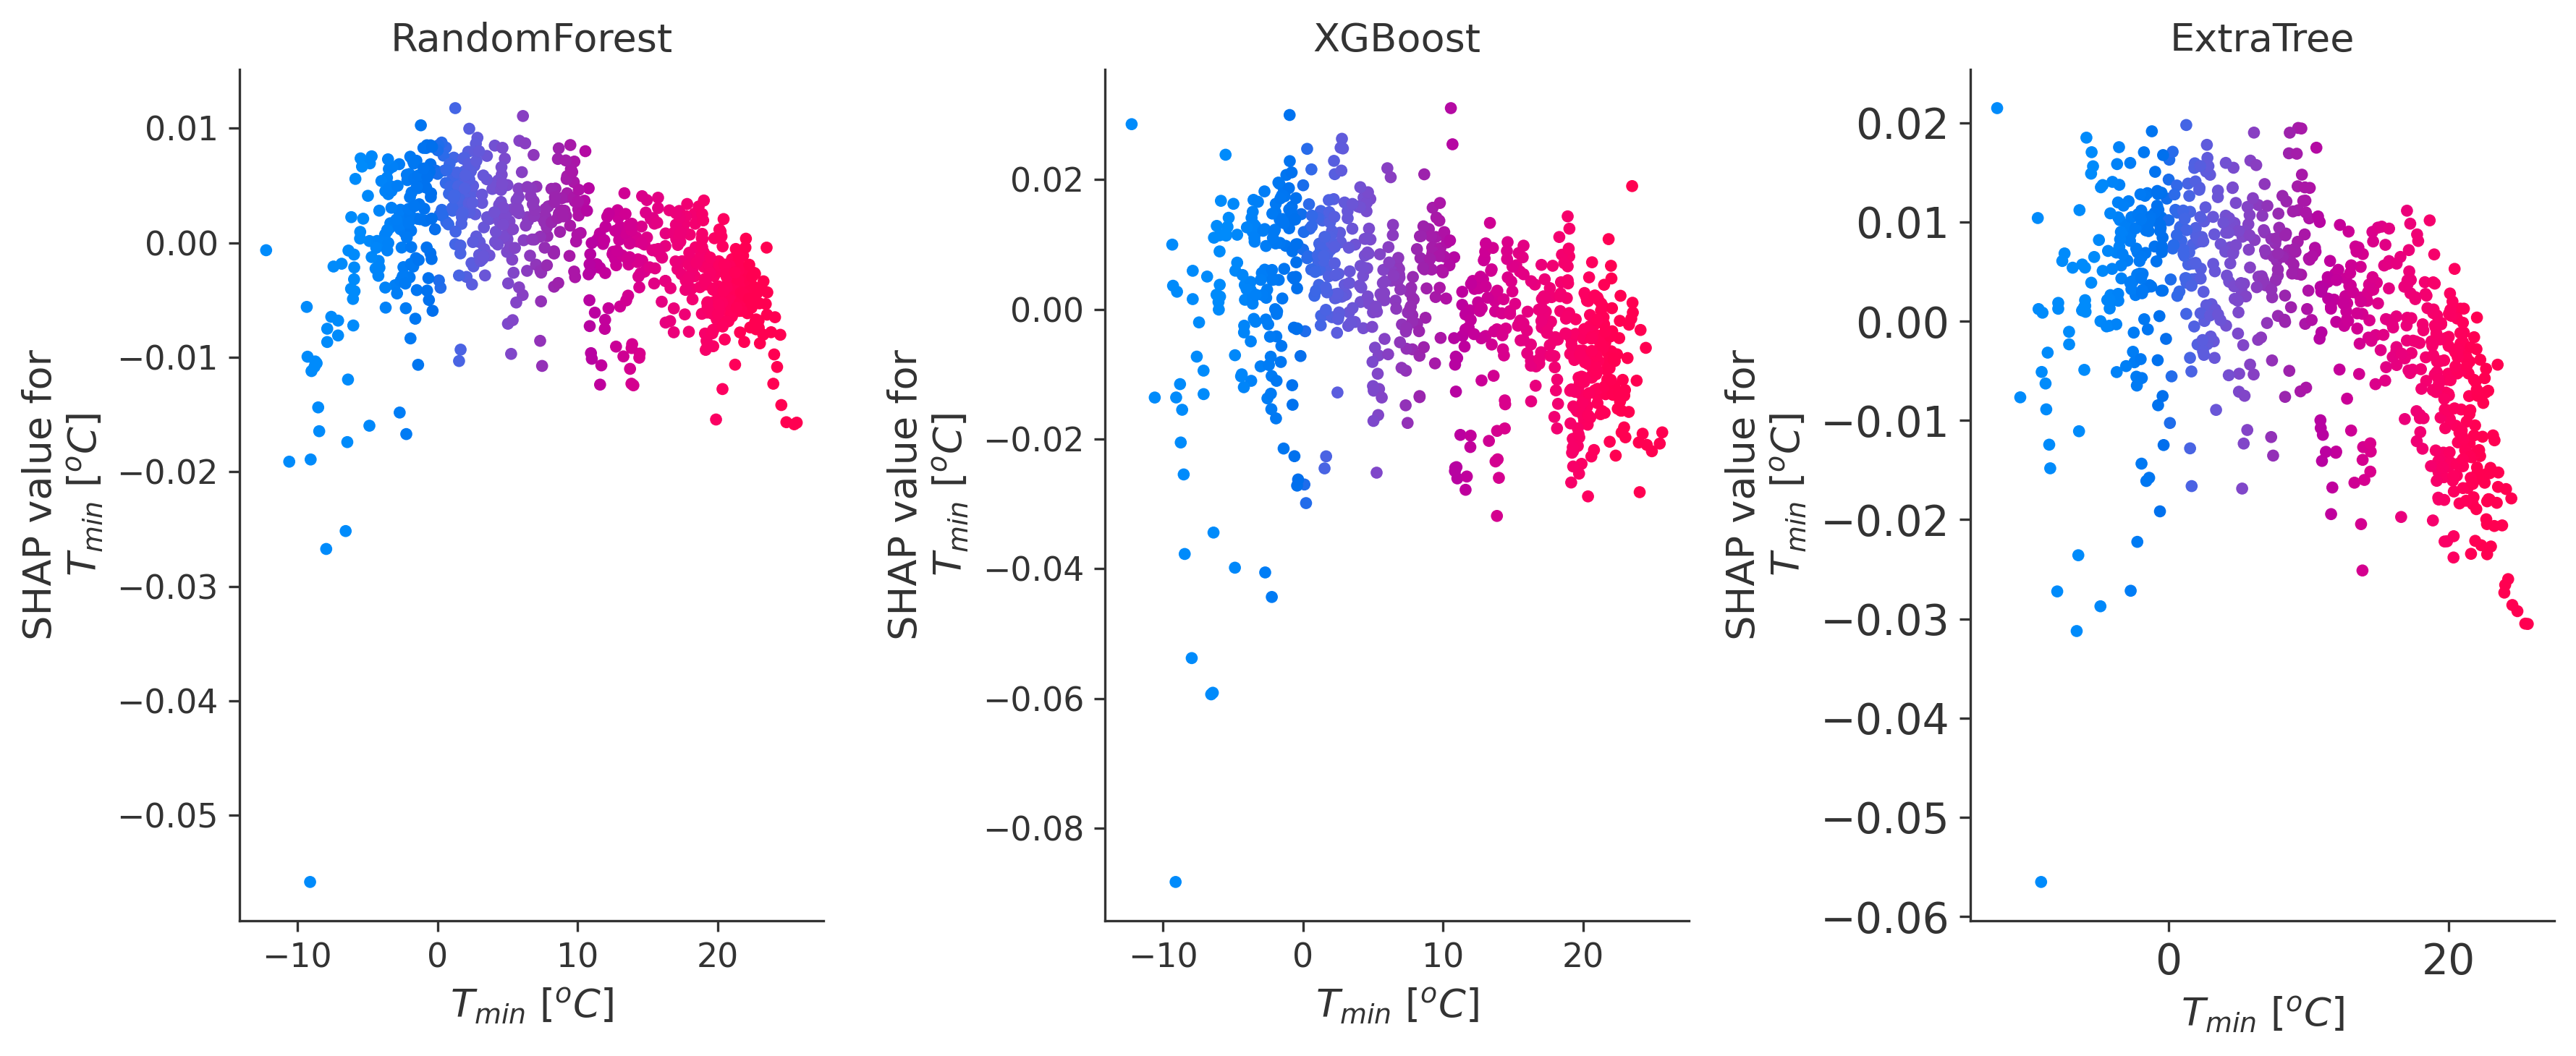

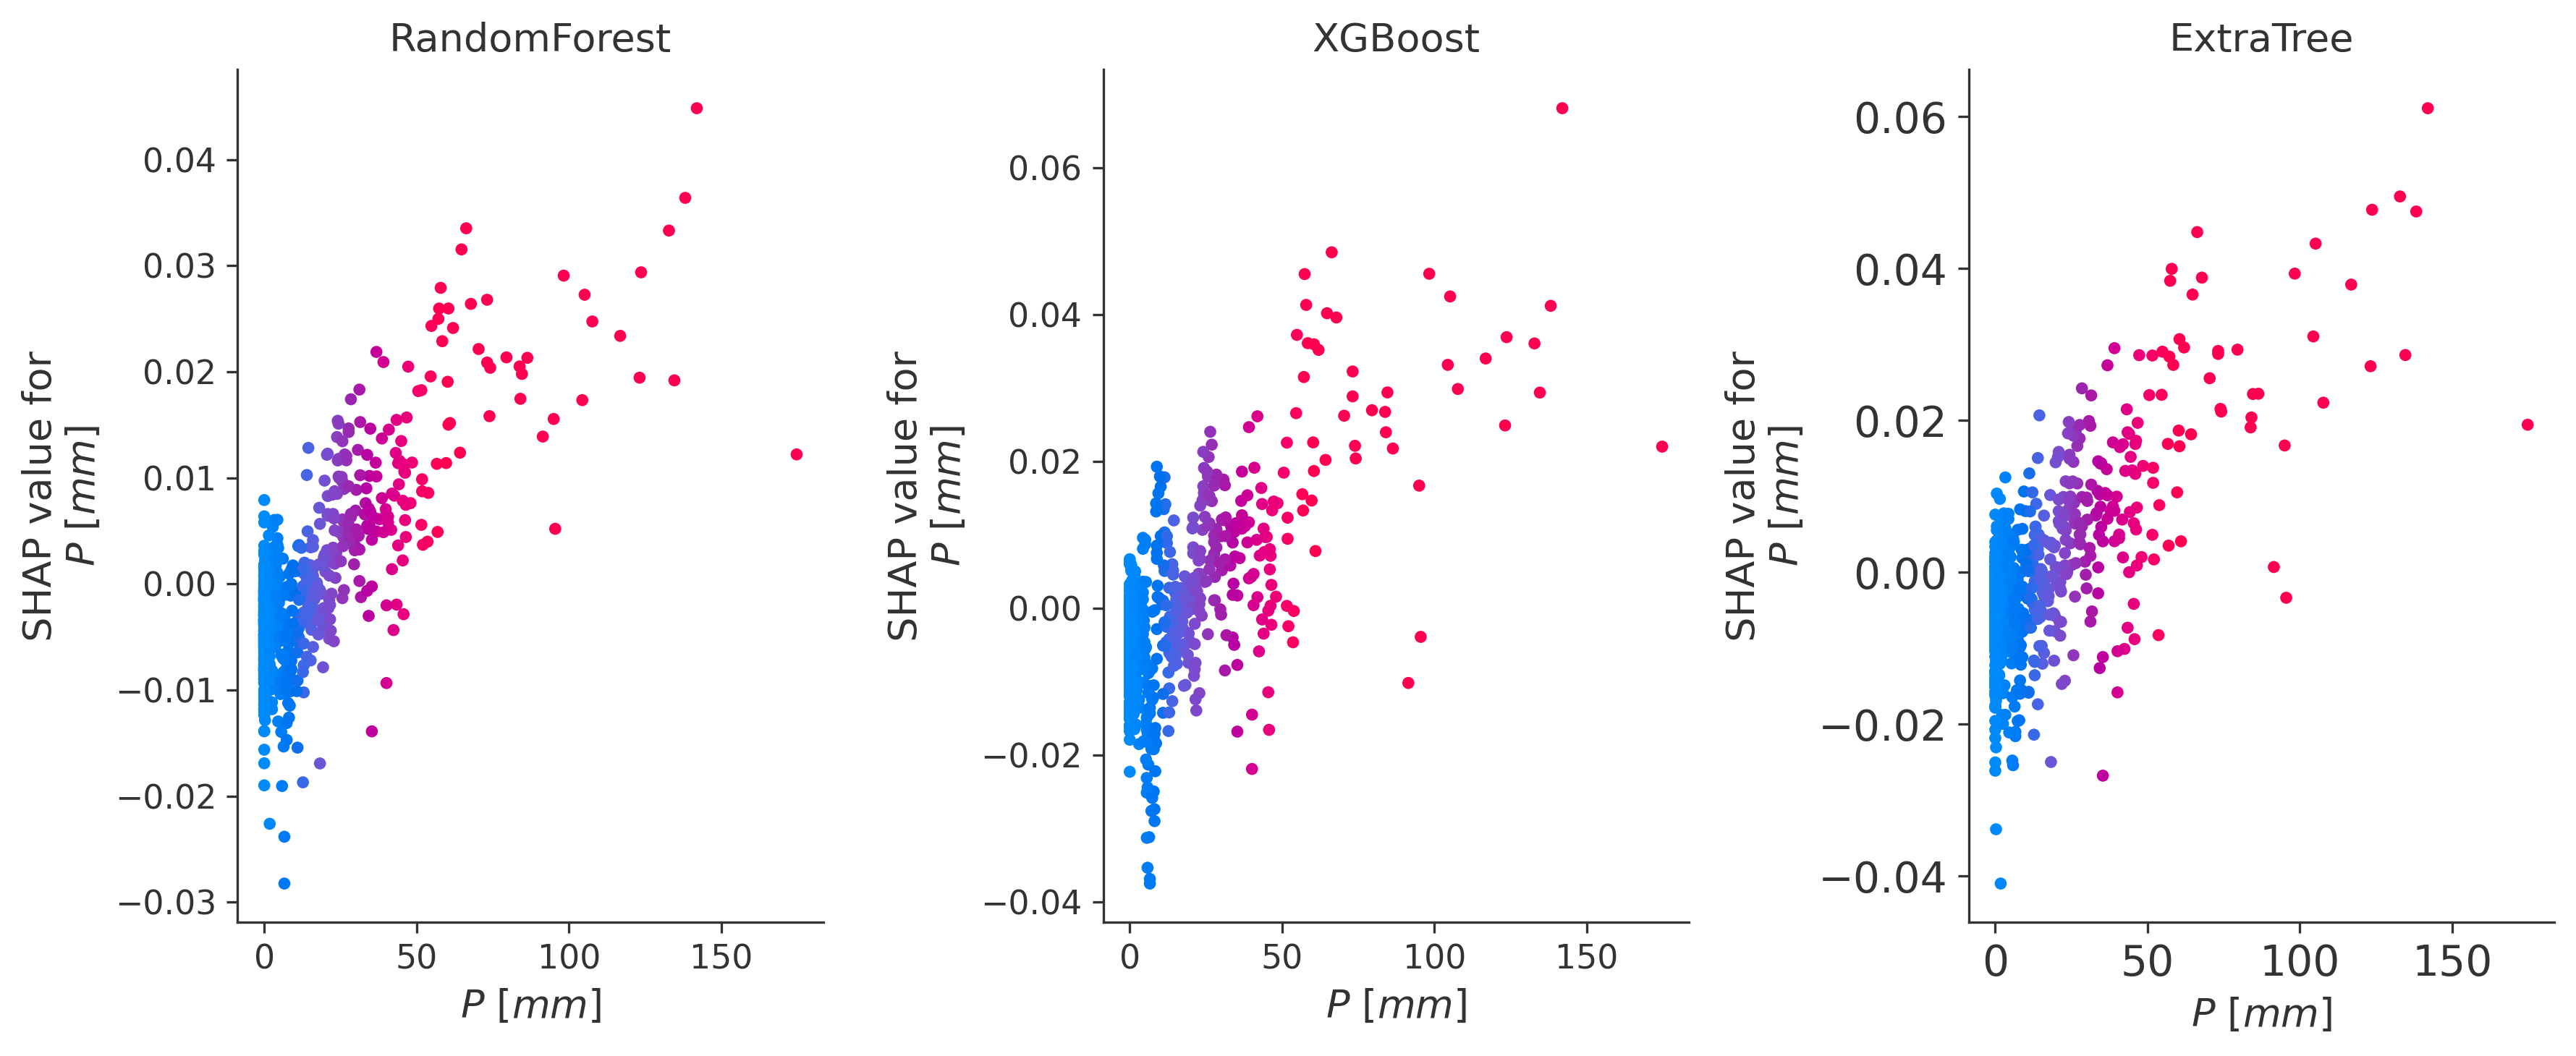

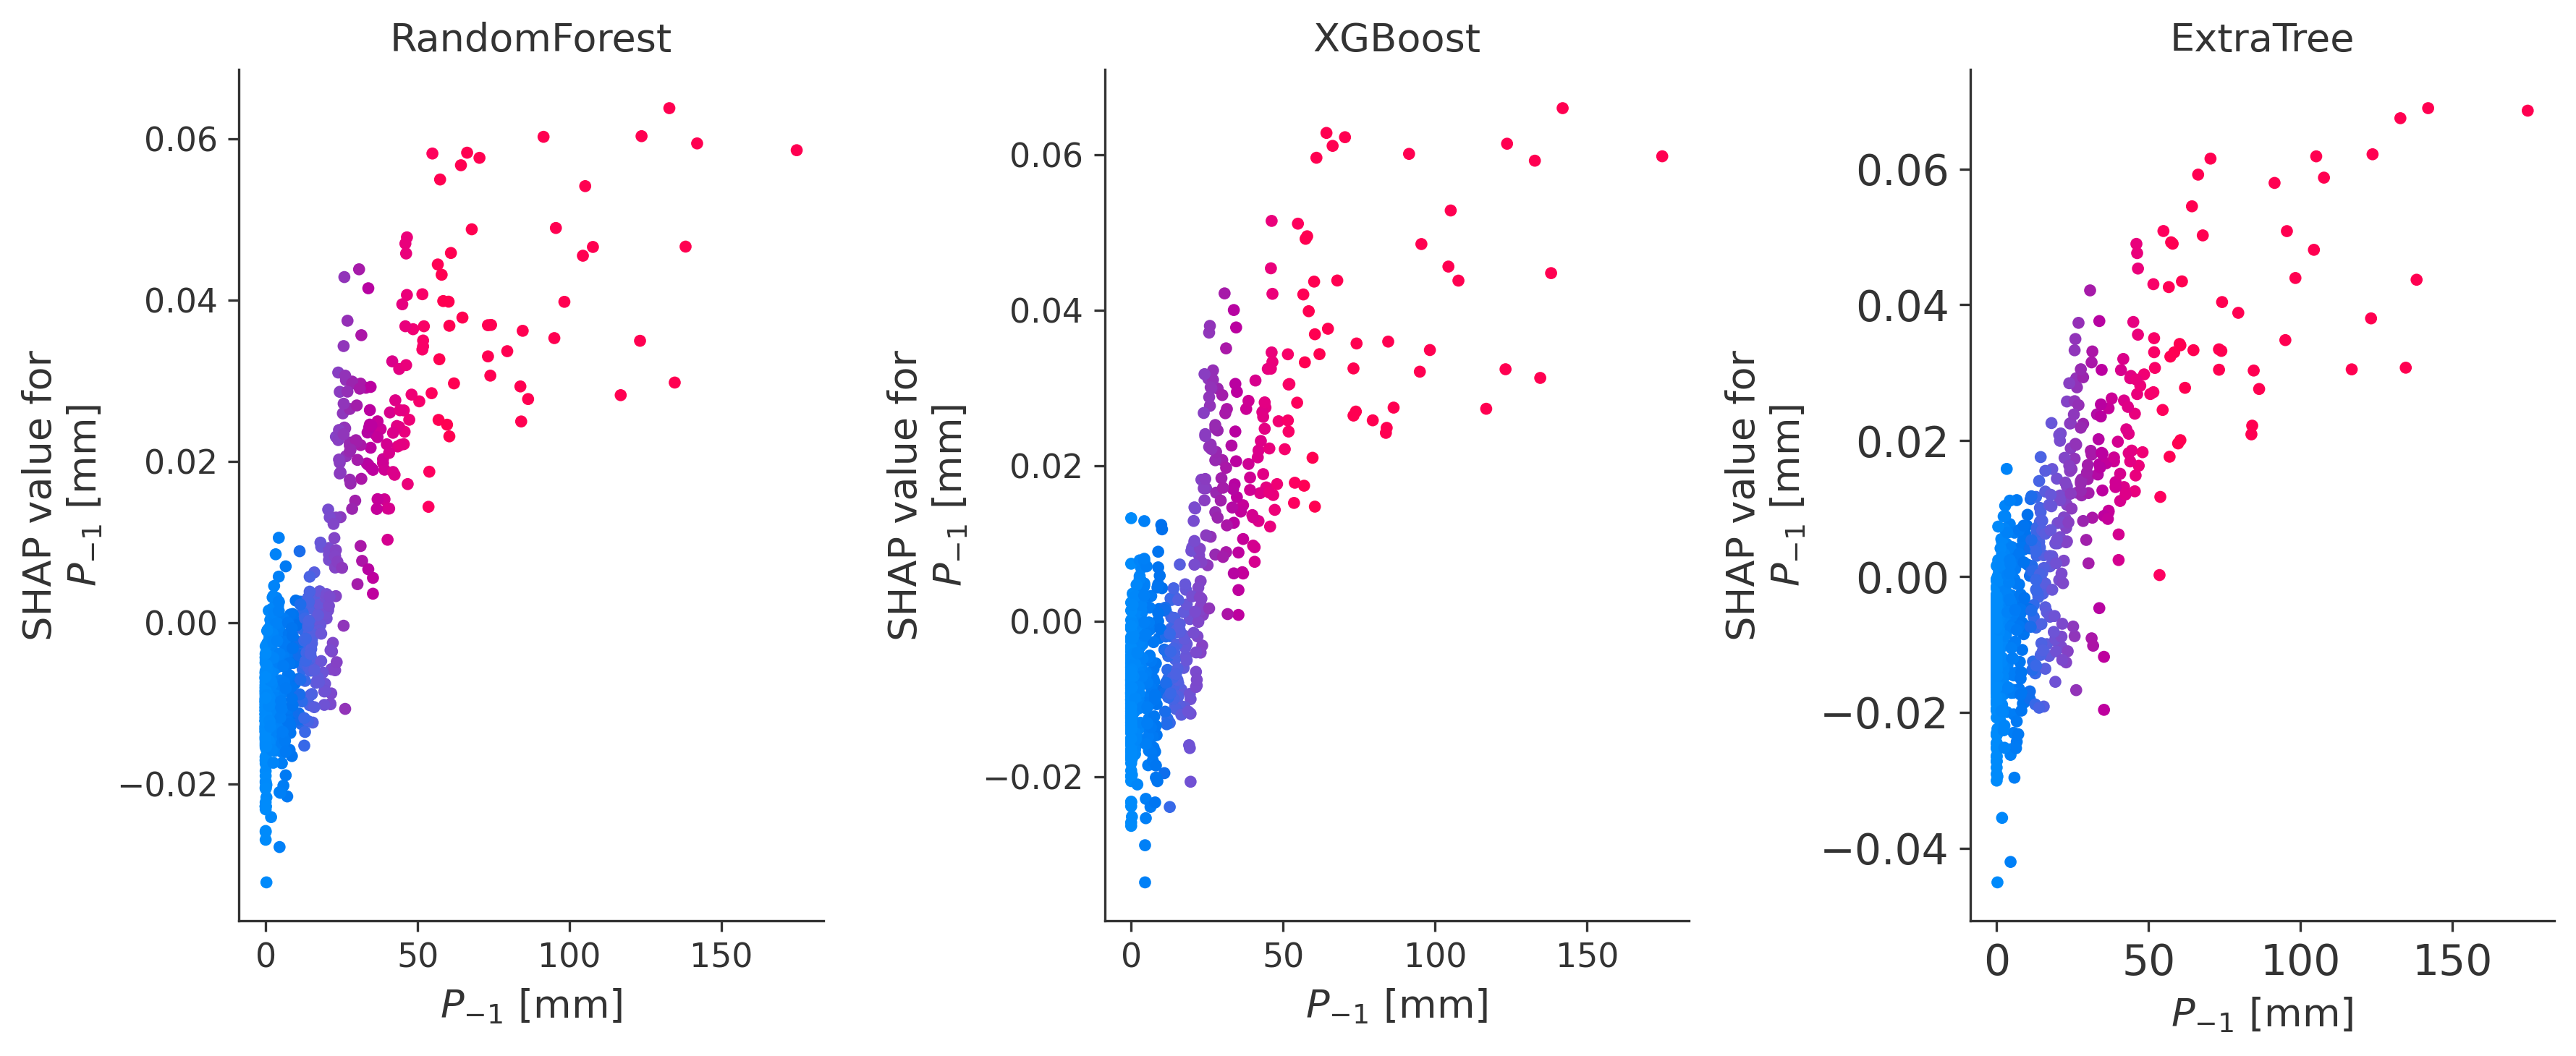

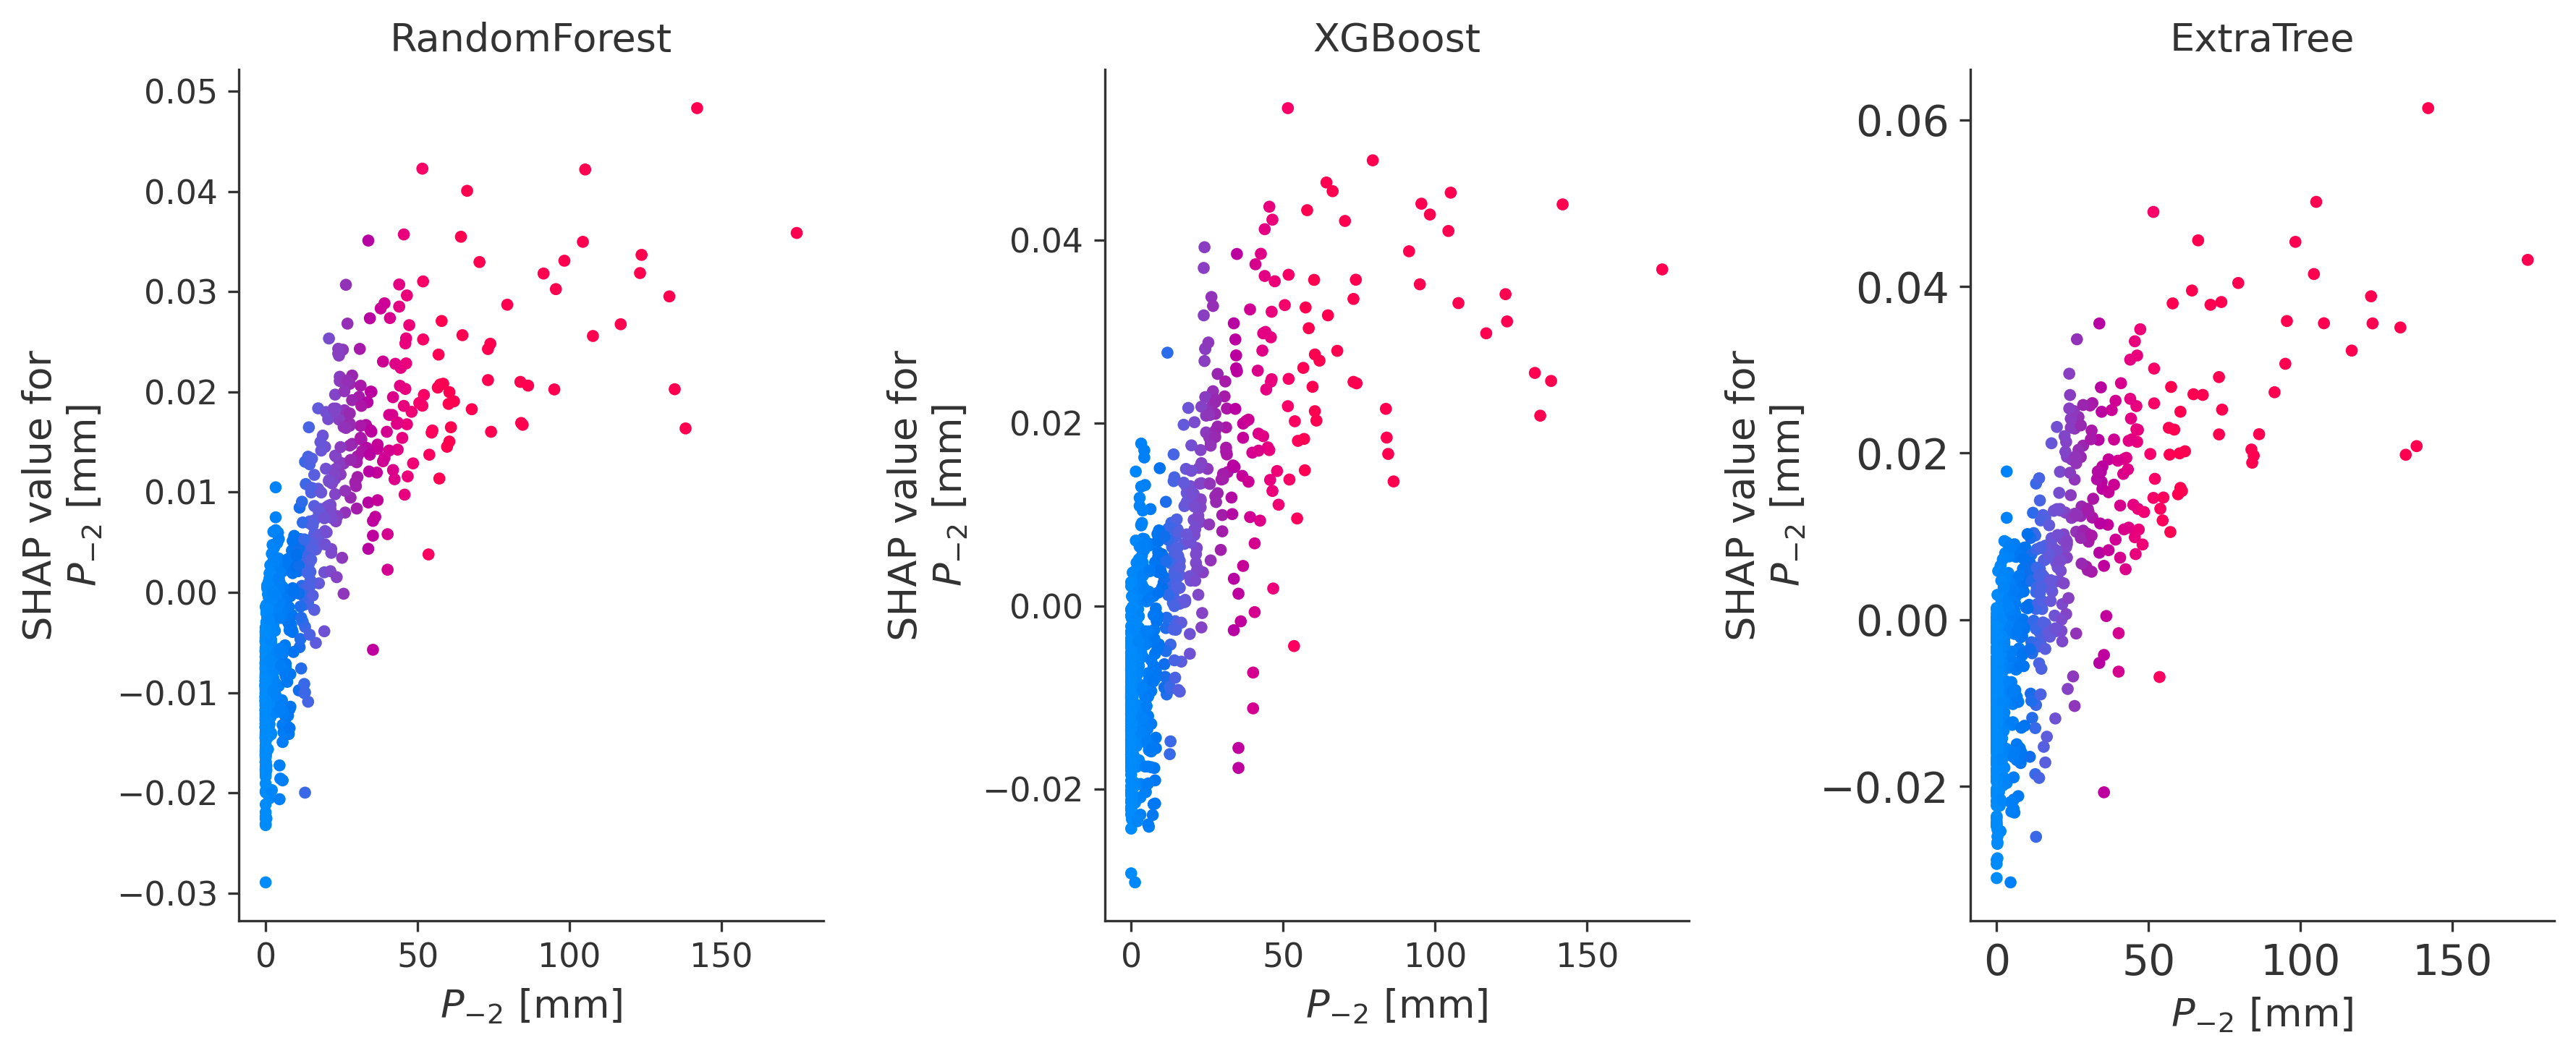

In [77]:
for i in Features:
    fig, ax = plt.subplots(1, 3, figsize=(12, 5), dpi=300)
    for count, j in enumerate(keep):
        shap.dependence_plot(i, keep[j], X, Features, ax=ax[count], show=False,
                             interaction_index=i, title=j)
        #ax[count].title(j, fontsize=14)
        plt.tick_params(labelsize=14)
        # plt.ylabel(labelsize=16)
        plt.tight_layout(pad=1.2)
        plt.savefig(path_to_save+r'/Feature Interaction_' + str(j)+'.jpg',
                    format='jpeg', dpi=300, bbox_inches='tight')


The above feature dependency plot is to be improved as we get more data. 

## Load the yearly crop yield and SPEI data

In [ ]:
current_directory = os.getcwd()
file_location = r'/Inputs/Lake Creek Crop Yield Data.xlsx'

crop_yield = pd.read_excel(
    current_directory+file_location, engine="openpyxl", sheet_name=None)
crop_yield.keys()


In [ ]:
crop_yield = crop_yield['Caddo County Wheat Yield']
crop_yield = crop_yield.set_index('Year',).dropna()
crop_yield = crop_yield.iloc[::-1]
crop_yield 

In [ ]:
current_directory = os.getcwd()
file_location = r'/Inputs/caddo_SPEI.xlsx'

spei = pd.read_excel(
    current_directory+file_location, engine="openpyxl", sheet_name="spei12")

spei_yearly = spei.sort_values(by = 'Years').set_index("Years")
spei_yearly["SPEI_Avg"] = spei_yearly.median(axis=1)

spei_yearly

In [ ]:
# Resample the temperature
resampled_yearly = df_F108[['TMAX (C)', "TMIN (C)"]].resample('Y').median()
# Resample the Precipitation & Discharge sum
resampled_yearly["PRCP_sum (mm)"] = df_F108["PRCP (mm)"].resample('Y').sum()
resampled_yearly["Dis_sum (CMS)"] = df_F108["CMS"].resample('Y').sum()
# Resample the SM
resampled_SM_yearly = df_F108.iloc[:, 4:].resample('Y').median()
# The transformed precipitation mean and median

df_F108_resampled_yearly = resampled_yearly.merge(resampled_SM_yearly, on='Date', how="inner")

df_F108_resampled_yearly['SPEI_Avg'] = spei_yearly["SPEI_Avg"].values



df_F108_resampled_yearly['bu/ac *'] = crop_yield['bu/ac *'].values
#df_F108_resampled_yearly['t/ha'] = crop_yield['t/ha'].values

corr_plot(df_F108_resampled_yearly, 'Data correlation plot')


In [ ]:
df_F108_resampled_yearly